<a href="https://www.kaggle.com/code/dsptlp/sonify?scriptVersionId=209949910" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
from IPython.display import HTML, display

url = "https://github.com/pparkitn/kaggle/blob/main/Images/sonify/Sonify_office_workers2.png?raw=true"
display(HTML(f'<img src="{url}" style="max-width:100%;">'))

# Sonify Analytics
- Analyzing the Performance of the Customer Base for Sonify

In [2]:
# Install Spark
!pip install pyspark > pyspark_install_log.txt

# Database interaction imports
import csv, sqlite3
import networkx as nx
import matplotlib.pyplot as plt

# Time-related imports
from time import strftime

# Data manipulation imports
import pandas as pd
import numpy as np
# Suppress specific warning about use_inf_as_na
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn._oldcore")

# Visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import MaxNLocator
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.patches as patches

# Miscellaneous imports
import math
import os
import sys
import gc
from IPython.display import Image, display


from pyspark.sql import SparkSession
from pyspark import SparkConf

# Set seaborn style
sns.set(style="whitegrid", font_scale=1.5)

## SQLITE
- The dataset for Sonify is in a SQLite DB
- Below is the Database Schema

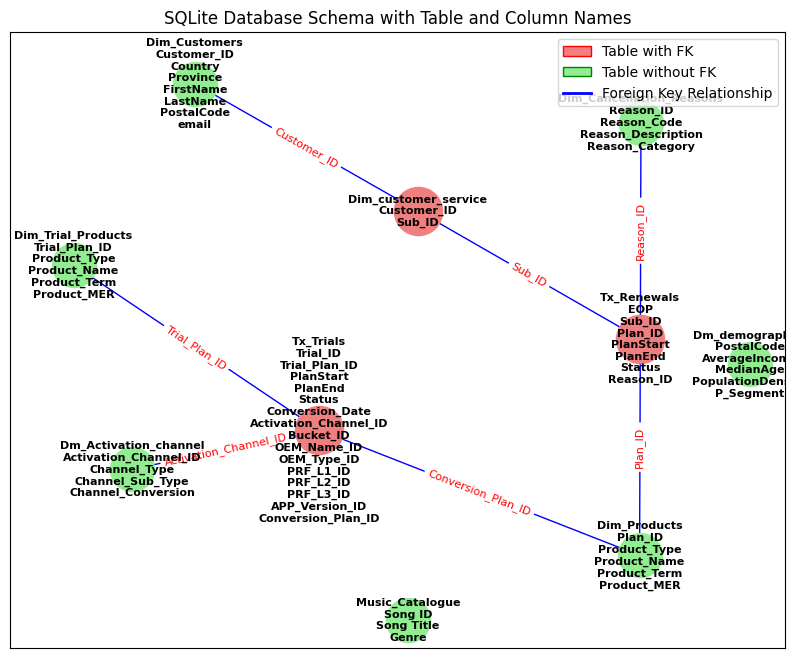

In [3]:
db_file = "/kaggle/input/sonify-synthetic-music-service/Sonify_DB.db"

# Display the image
display(Image(filename='/kaggle/input/sonify-synthetic-music-service/database_schema.png'))

## SPARK
- To speed up query selection we will use Spark
- First Step is to Setup Spark
- Load the data into Spark

### Setup Spark

In [4]:
# Check the number of CPU cores available
print("Number of CPU cores:", os.cpu_count())

Number of CPU cores: 4


In [5]:
%%time

# Configure Spark with increased memory
conf = SparkConf() \
    .set("spark.driver.memory", "8g") \
    .set("spark.executor.memory", "8g") \
    .set("spark.executor.cores", "2")

# Initialize the Spark Session
spark = SparkSession.builder \
    .appName("Spark SQL Database") \
    .master("local[*]") \
    .config(conf=conf) \
    .config("spark.sql.warehouse.dir", "/user/hive/warehouse") \
    .config("spark.sql.execution.arrow.enabled", "true") \
    .enableHiveSupport() \
    .getOrCreate()

# Set log level to "ERROR" to minimize warnings
spark.sparkContext.setLogLevel("ERROR")

# Create a new database
spark.sql("CREATE DATABASE IF NOT EXISTS sonify")

# Verify by listing all databases
spark.sql("SHOW DATABASES").show()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/27 14:53:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+---------+
|namespace|
+---------+
|  default|
|   sonify|
+---------+

CPU times: user 40.4 ms, sys: 26.7 ms, total: 67.1 ms
Wall time: 18.3 s


### LOAD SPARK FROM SQLITE

In [6]:
%%time

con = sqlite3.connect(db_file) 

Tx_Renewals_df = pd.read_sql_query("""SELECT * from Tx_Renewals""", con)
Dim_Products_df = pd.read_sql_query("""SELECT * from Dim_Products""", con)
Dim_Cancellation_Reasons_df = pd.read_sql_query("""SELECT * from Dim_Cancellation_Reasons""", con)
Dim_Customers_df = pd.read_sql_query("""SELECT * from Dim_Customers""", con)
Tx_Trials_df = pd.read_sql_query("""SELECT * from Tx_Trials""", con)
DM_demographics_df = pd.read_sql_query("""SELECT * from DM_demographics""", con)
con.close()

# Convert Pandas DataFrame to Spark DataFrame
Tx_Renewals_df = spark.createDataFrame(Tx_Renewals_df)
Tx_Trials_df = spark.createDataFrame(Tx_Trials_df)
Dim_Products_df = spark.createDataFrame(Dim_Products_df)
Dim_Cancellation_Reasons_df = spark.createDataFrame(Dim_Cancellation_Reasons_df)
Dim_Customers_df = spark.createDataFrame(Dim_Customers_df)
DM_demographics_df = spark.createDataFrame(DM_demographics_df)

# Set the current database
spark.sql("USE sonify")

Tx_Renewals_df.write.mode("overwrite").saveAsTable("Tx_Renewals")
Tx_Trials_df.write.mode("overwrite").saveAsTable("Tx_Trials")
Dim_Products_df.write.mode("overwrite").saveAsTable("Dim_Products")
Dim_Cancellation_Reasons_df.write.mode("overwrite").saveAsTable("Dim_Cancellation_Reasons")
Dim_Customers_df.write.mode("overwrite").saveAsTable("Dim_Customers")
DM_demographics_df.write.mode("overwrite").saveAsTable("Dim_demographics")

# Verify by querying the table
spark.sql("SELECT * FROM Tx_Renewals").show(2)
spark.sql("SELECT * FROM Dim_Products").show(2)
spark.sql("SELECT * FROM Dim_Cancellation_Reasons").show(2)
spark.sql("SELECT * FROM Dim_Customers").show(2)
spark.sql("SELECT * FROM Tx_Trials").show(2)
spark.sql("SELECT * FROM Dim_demographics").show(2)


# Verify by querying the table
spark.sql("SELECT count(*) cnt FROM Tx_Renewals").show(2)
spark.sql("SELECT count(*) FROM Dim_Customers").show(2)
spark.sql("SELECT count(*) FROM Tx_Trials").show(2)

+----------+------+-------+-------------------+-------------------+------+---------+
|       EOP|Sub_ID|Plan_ID|          PlanStart|            PlanEnd|Status|Reason_ID|
+----------+------+-------+-------------------+-------------------+------+---------+
|2024-10-31|249844|      4|2024-10-22 00:00:00|2024-11-22 00:00:00|Active|     NULL|
|2024-10-31|249847|      4|2024-10-20 00:00:00|2024-11-20 00:00:00|Active|     NULL|
+----------+------+-------+-------------------+-------------------+------+---------+
only showing top 2 rows

+-------+------------+--------------------+------------+-----------+
|Plan_ID|Product_Type|        Product_Name|Product_Term|Product_MER|
+-------+------------+--------------------+------------+-----------+
|      8|      Silver|Silver - Family -...|          12|      20.99|
|      9|        Gold|Gold - Individual...|           3|      12.99|
+-------+------------+--------------------+------------+-----------+
only showing top 2 rows

+---------+-----------+---

+-------+
|    cnt|
+-------+
|9960925|
+-------+

+--------+
|count(1)|
+--------+
|  730000|
+--------+

+--------+
|count(1)|
+--------+
| 1000000|
+--------+

CPU times: user 48.5 s, sys: 10.8 s, total: 59.3 s
Wall time: 2min 13s


## BASE

### BASE BY EOP

In [7]:
%%time

df  = spark.sql("SELECT EOP, count(*) cnt from Tx_Renewals Group by EOP Order by EOP").toPandas()
df.head(4)

CPU times: user 26.6 ms, sys: 7.8 ms, total: 34.4 ms
Wall time: 5.88 s


,EOP,cnt
0,2021-01-31,100000
1,2021-02-28,114000
2,2021-03-31,121298
3,2021-04-30,128408


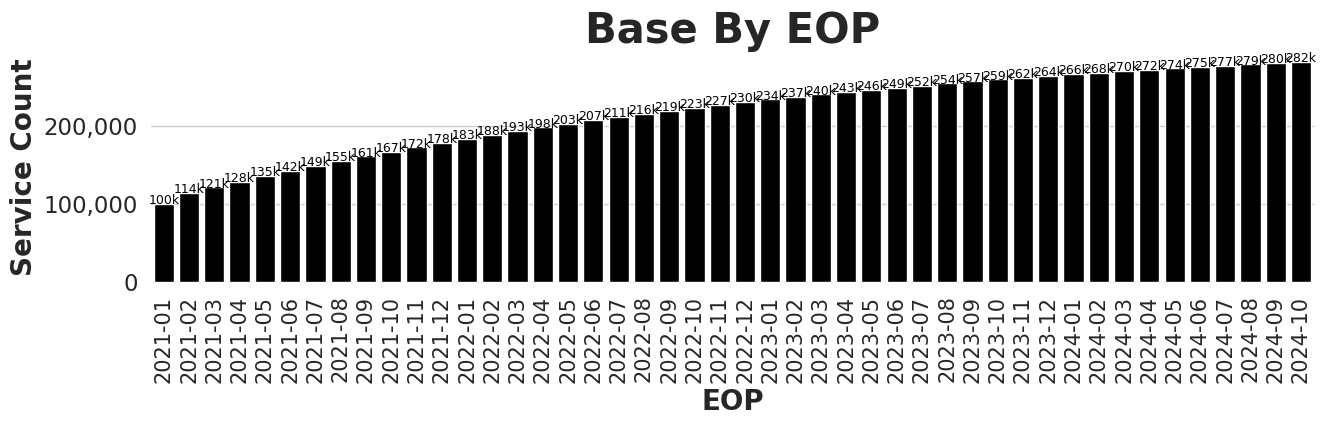

In [8]:
# Set up the figure and axis
f, ax = plt.subplots(figsize=(15, 3))

# Set style and font size for Seaborn
sns.set(style="whitegrid", font_scale=1.5)

# Barplot for the self-pay base data
sns.barplot(x="EOP", y="cnt", data=df, color='black')

# Customize x-axis and y-axis ticks
plt.xticks(rotation=90)
plt.ticklabel_format(style='plain', axis='y')
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
#ax.set(ylim=(0, 30))  # Using underscore for readability

# Remove spines for a cleaner look
sns.despine(left=True, bottom=True)

# Truncate x-axis labels to show only year and month
labels = [item.get_text()[:7] for item in ax.get_xticklabels()]
ax.set_xticklabels(labels, rotation=90, fontsize=15)

# Set axis labels and title
ax.set_xlabel('EOP', fontdict={'size': 20, 'weight': 'bold'})
ax.set_ylabel('Service Count', fontdict={'size': 20, 'weight': 'bold'})
ax.set_title("Base By EOP", fontdict={'size': 30, 'weight': 'bold'})

# Annotate values on top of the bars
for i, v in enumerate(df['cnt']):
    ax.text(i, v + 0.1, f'{v/1000:,.0f}k', color='black', ha='center', fontsize=9)

# Save the figure
f.savefig('BASE_BY_EOP.png', transparent=True, bbox_inches='tight', pad_inches=0.15, dpi=100)


### BASE BY PLAN

In [9]:
%%time

df  = spark.sql("""
SELECT EOP, 
Product_name,
count(*) cnt 
from Tx_Renewals AL1
LEFT JOIN Dim_Products AL2 ON AL1.Plan_ID = AL2.Plan_ID
Group by EOP, Product_name
Order by EOP""").toPandas()
df.head(4)

CPU times: user 23.5 ms, sys: 7.33 ms, total: 30.8 ms
Wall time: 6.36 s


,EOP,Product_name,cnt
0,2021-01-31,Gold - Individual - Quarterly,5000
1,2021-01-31,Bronze - Student - Monthly,5000
2,2021-01-31,Bronze - Duo - Monthly,5000
3,2021-01-31,Gold - Student - Quarterly,5000


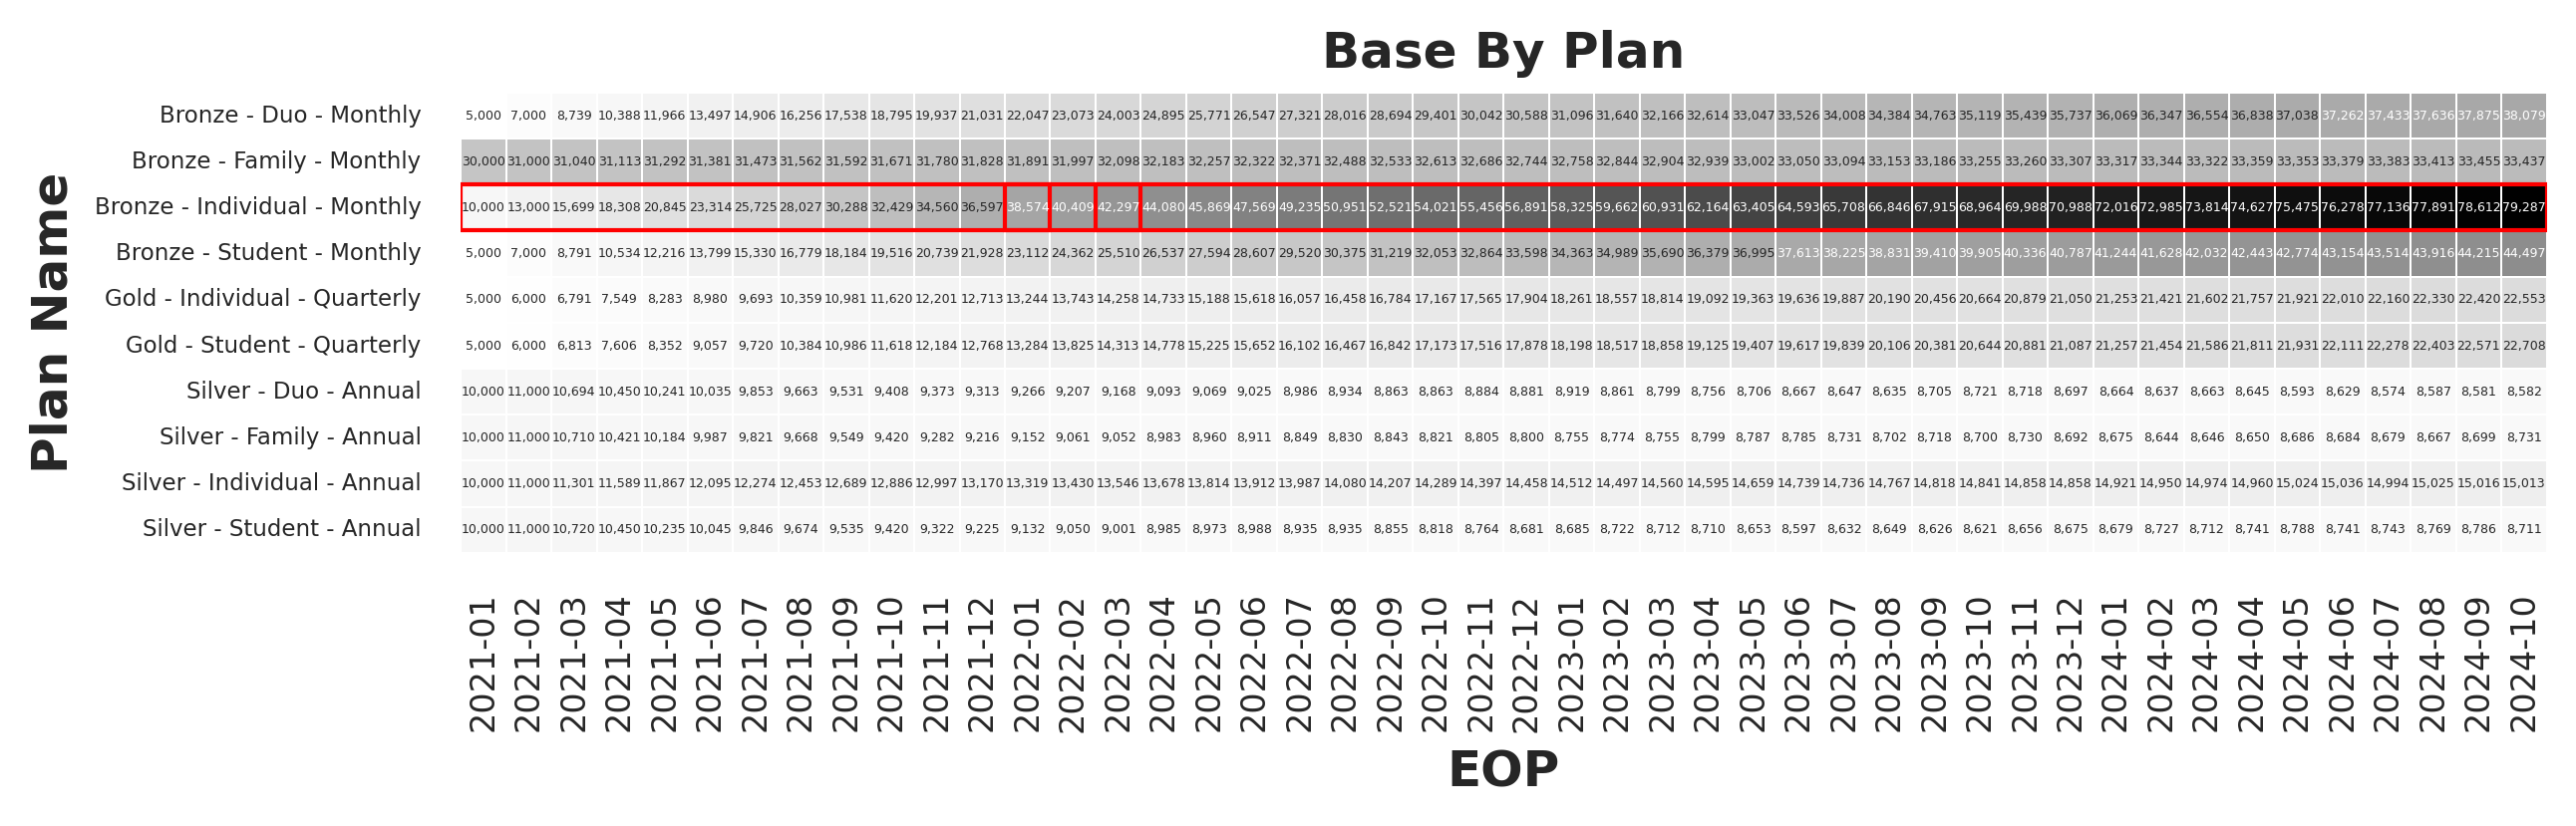

In [10]:
# Pivot the DataFrame
DATA_DF2 = df.pivot(index='Product_name', columns='EOP', values='cnt')

# Set Seaborn style
sns.set(style="whitegrid", font_scale=0.5)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(9, 2), dpi=300)

# Create a heatmap
sns.heatmap(DATA_DF2,
            annot=True,
            cbar=False,
            linewidths=0.1,
            annot_kws={"size": 3},
            fmt=',.0f',
            square=False,
            cmap="Greys",
            ax=ax)

# Customize tick labels
plt.yticks(rotation=0)
plt.xticks(rotation=90)

# Truncate x-axis labels to show only year and month
labels = [item.get_text()[:7] for item in ax.get_xticklabels()]
ax.set_xticklabels(labels, rotation=90, fontsize=8)

# Set axis labels and title
ax.set_xlabel('EOP', fontdict={'size': 12, 'weight': 'bold'})
ax.set_ylabel('Plan Name', fontdict={'size': 12, 'weight': 'bold'})
ax.set_title("Base By Plan", fontdict={'size': 12, 'weight': 'bold'})

# Drawing a red box around specific rows
rows_to_highlight = ['Bronze - Individual - Monthly'] 

for i, row_label in enumerate(DATA_DF2.index):
    if row_label in rows_to_highlight:
        rect = patches.Rectangle((0, i), len(DATA_DF2.columns), 1, linewidth=1, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        
# Drawing a red box around specific cells
cells_to_highlight = [
    ('Bronze - Individual - Monthly', '2022-01-31'),
    ('Bronze - Individual - Monthly', '2022-03-31')
]

for y_label, x_label in cells_to_highlight:
    y_index = DATA_DF2.index.get_loc(y_label)
    x_index = DATA_DF2.columns.get_loc(x_label)
    rect = patches.Rectangle((x_index, y_index), 1, 1, linewidth=1, edgecolor='red', facecolor='none')
    ax.add_patch(rect)          

fig.savefig('BASE_BY_PLAN.png',transparent=False,  bbox_inches='tight',pad_inches=0.15,dpi=400)

### BASE BY MER

In [11]:
%%time

df  = spark.sql("""
SELECT EOP, 
avg(Product_MER) mer,
count(*) cnt 
from Tx_Renewals AL1
LEFT JOIN Dim_Products AL2 ON AL1.Plan_ID = AL2.Plan_ID
Group by EOP
Order by EOP""").toPandas()
df.head(4)

CPU times: user 22.8 ms, sys: 4.48 ms, total: 27.3 ms
Wall time: 4.88 s


,EOP,mer,cnt
0,2021-01-31,15.740000,100000
1,2021-02-28,15.463684,114000
2,2021-03-31,15.242477,121298
3,2021-04-30,15.053127,128408


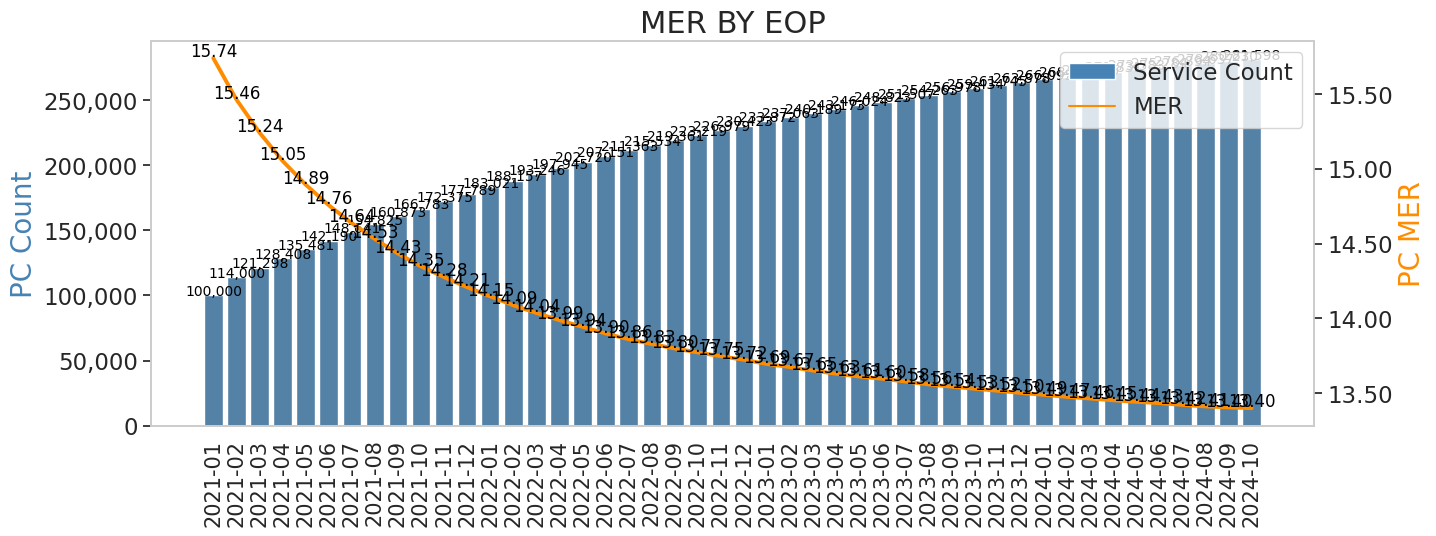

In [12]:
x = pd.Series(df['EOP'])  # Convert to pandas Series
y1 = df['cnt']
y2 = df['mer']

# Handle infinite values explicitly
df.replace([float('inf'), -float('inf')], float('nan'), inplace=True)

sns.set(style="whitegrid", font_scale=1.5)

# Create figure and axes
f, ax1 = plt.subplots(figsize=(15, 5),frameon = True)

# Plot the bar chart on the primary y-axis
bar = sns.barplot(x=x, y=y1, ax=ax1, color='steelblue')
ax1.set_ylabel('PC Count', color='steelblue', fontsize=20)
#ax1.set_ylim([2050000, 2250000])

# Add values on top of the bars
for i, v in enumerate(y1):
    ax1.text(i + 0.02, v + 2, '{:,.0f}'.format(v), color='black', ha='center',fontsize=10)

plt.xticks(rotation=90) 
ax2 = ax1.twinx()

# Plot the line chart on the secondary y-axis
line = sns.lineplot(x=x, y=y2, ax=ax2, color='darkorange',linewidth=2.8,markers=True,markersize=11)
ax2.set_ylabel('PC MER', color='darkorange', fontsize=20)
ax2.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x)))

# Add values on top of the bars
for i, v in enumerate(y2):
    ax2.text(i + 0.01, v + 0.01, '{:,.2f}'.format(v), color='black', ha='center',fontsize=12)

labels = [item.get_text()[:7] for item in ax1.get_xticklabels()]  # Get the current tick labels and truncate to year and month
ax1.set_xticklabels(labels, rotation=90, fontsize=15)  # Set the modified tick labels    
        
# Set x-axis label and title
ax1.set_xlabel('', fontsize=12)
ax1.set_title('MER BY EOP', fontsize=22)
ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

# Create legend with proxy artists
legend_labels = ['Service Count', 'MER']
legend_elements = [Patch(facecolor='steelblue', label='Bar Plot'),
                   Line2D([0], [0], color='darkorange', label='Line Plot')]
plt.legend(handles=legend_elements, labels=legend_labels)

# Disable the background grid lines
ax1.grid(False)
ax2.grid(False)

# Show the plot
plt.savefig("BASE_BY_MER.png",transparent=True,bbox_inches='tight',pad_inches=0.05,dpi=400) 
plt.show()

## Products

In [13]:
%%time

df  = spark.sql("""
SELECT EOP, 
Product_Type,
count(*) cnt 
from Tx_Renewals AL1
LEFT JOIN Dim_Products AL2 ON AL1.Plan_ID = AL2.Plan_ID
Group by EOP, Product_Type
Order by EOP""").toPandas()
df.head(4)

CPU times: user 17.8 ms, sys: 7.61 ms, total: 25.4 ms
Wall time: 4.23 s


,EOP,Product_Type,cnt
0,2021-01-31,Bronze,50000
1,2021-01-31,Gold,10000
2,2021-01-31,Silver,40000
3,2021-02-28,Silver,44000


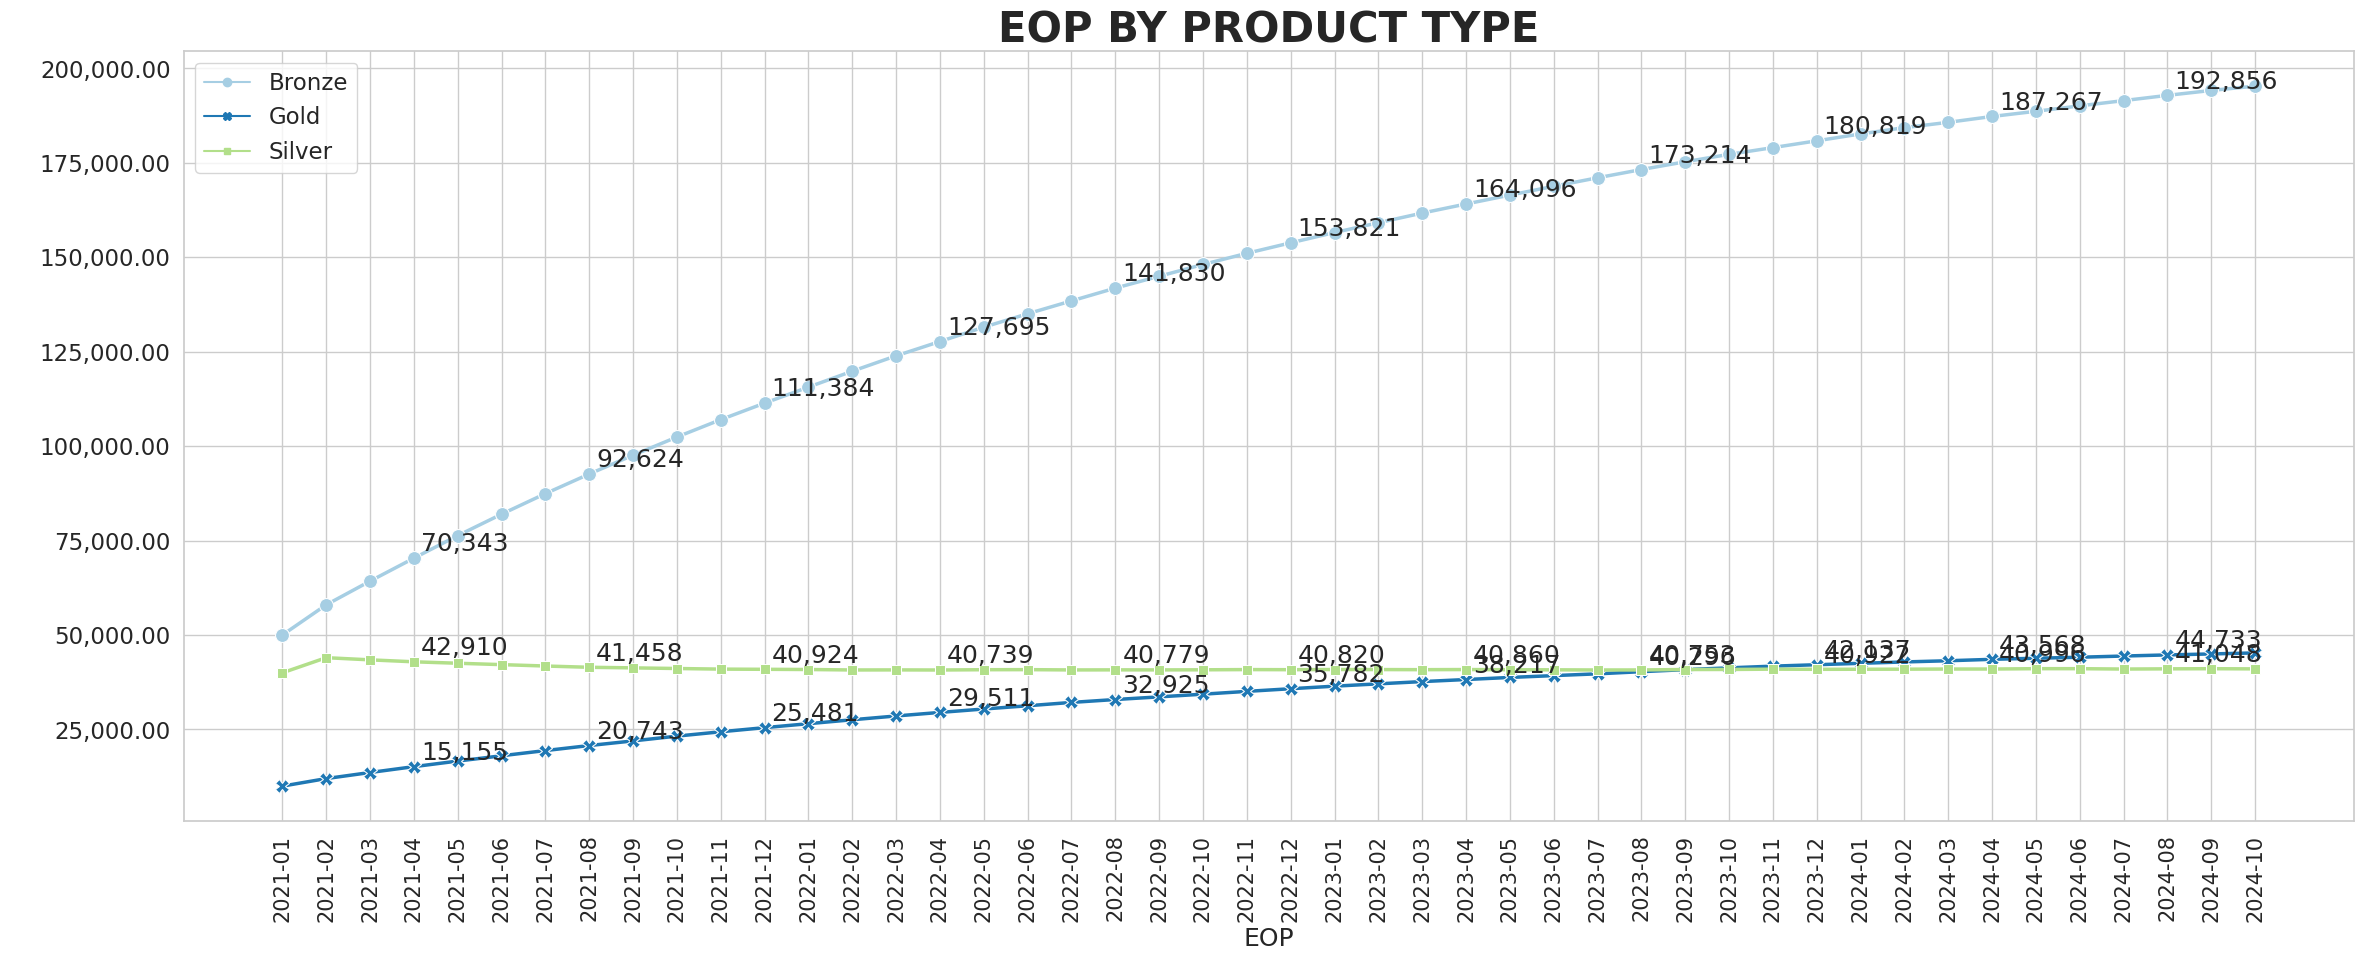

In [14]:
final_df = df[['EOP','Product_Type','cnt']]
final_df = final_df.pivot(index='EOP', columns='Product_Type', values='cnt')

sns.set(style="whitegrid", font_scale=1.5)

# Different color palettes you can use:
# sns.color_palette("deep")
# sns.color_palette("muted")
# sns.color_palette("bright")
# sns.color_palette("pastel")
# sns.color_palette("dark")
# sns.color_palette("colorblind")
# sns.color_palette("tab10")
# sns.color_palette("Set1")
# sns.color_palette("Set2")
# sns.color_palette("Set3")
# sns.color_palette("Paired")
# sns.color_palette("Accent")
# sns.color_palette("Spectral")
# sns.color_palette("coolwarm")
# sns.color_palette("viridis")
# sns.color_palette("plasma")
# sns.color_palette("inferno")
# sns.color_palette("magma")

fig, ax = plt.subplots(figsize=(28, 10),frameon =True)
sns.lineplot(data=final_df, palette="Paired", linewidth=2.5, markers=True, dashes=False, markersize=10, ax=ax)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x)))

ax.set_xticks(final_df.index)
ax.set_xlabel('EOP')
ax.set_ylabel('   ')
ax.set_title("EOP BY PRODUCT TYPE", fontdict={'size': 30, 'weight': 'bold'})
ax.legend(loc='upper left')
#plt.ylim(0, 15000)

ax.yaxis.set_major_locator(mtick.MaxNLocator(integer=True))  # Set y-axis ticks as integers
plt.xticks(rotation=90) 
counter = 0

for index, row in final_df.iterrows():
    counter = counter + 1
    y_list = []    
    
    if counter % 4 == 0:
    
        for col in row:                
            if not math.isnan(col):            
                display_flag = 1
                for value in y_list:
                    if abs(value - col) <= 40:
                        display_flag = 0

                if display_flag ==1:
                    ax.annotate(f'{col:,.0f}', xy=(index, col), xytext=(5, 5), textcoords='offset points')            
                y_list.append(col)

labels = [item.get_text()[:7] for item in ax1.get_xticklabels()]  # Get the current tick labels and truncate to year and month
ax.set_xticklabels(labels, rotation=90, fontsize=15)  # Set the modified tick labels               
            
plt.savefig("BASE_BY_PRODUCT.png", transparent=True, bbox_inches='tight', pad_inches=0.05, dpi=500)
plt.show()

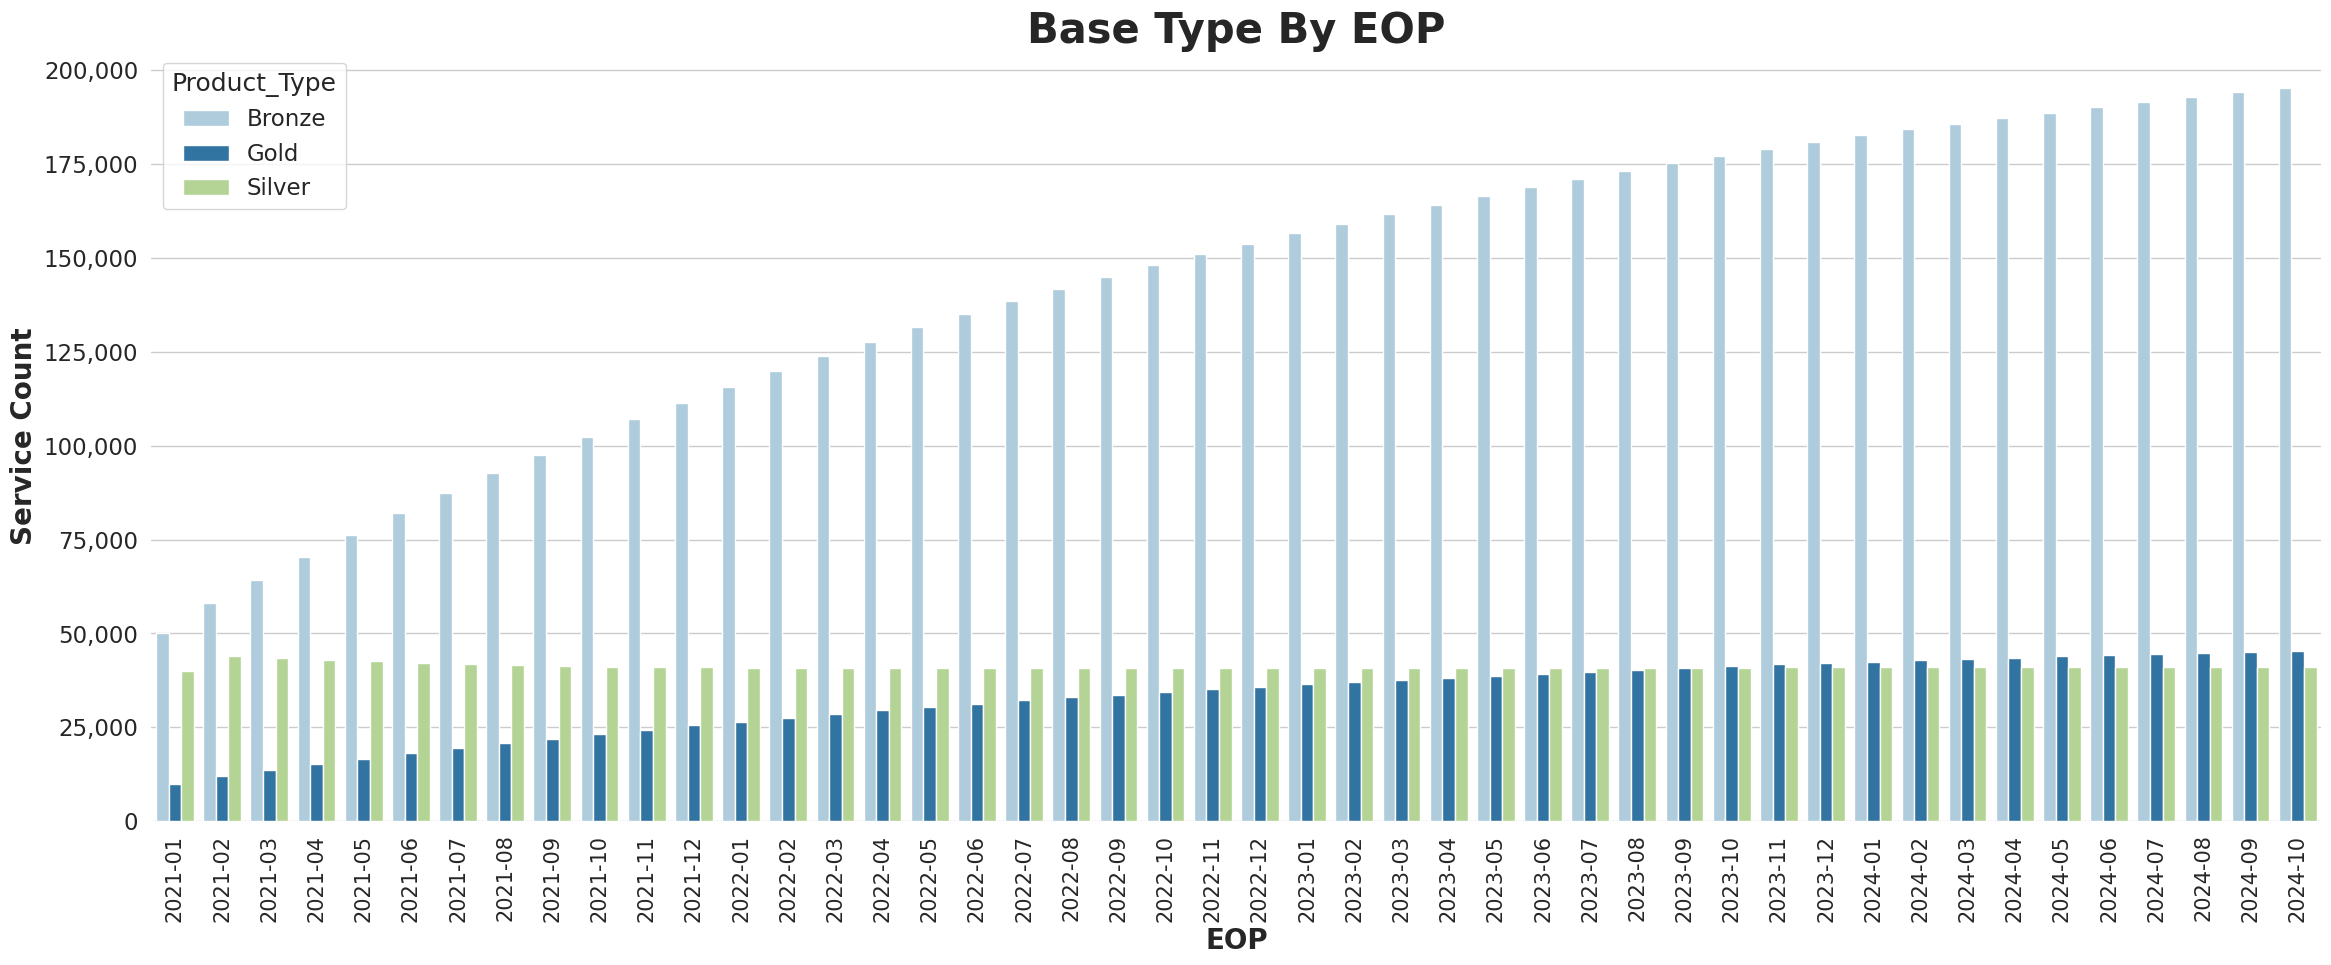

In [15]:
# Set Seaborn style
sns.set(style="whitegrid", font_scale=1.5)

# Create a figure and axis
#f, ax = plt.subplots(figsize=(28, 10))
f, ax = plt.subplots(figsize=(28, 10),frameon =True)

# Create a barplot with hue for ServiceCategory
sns.barplot(data=df, x='EOP', y='cnt', palette="Paired", hue='Product_Type')

# Customize x-axis and y-axis
plt.xticks(rotation=90)
plt.ticklabel_format(style='plain', axis='y')
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
#ax.set(ylim=(0, 2_300_000))  # Using underscore for readability

# Remove spines for a cleaner look
sns.despine(left=True, bottom=True)

# Truncate x-axis labels to show only year and month
labels = [item.get_text()[:7] for item in ax.get_xticklabels()]
ax.set_xticklabels(labels, rotation=90, fontsize=15)

# Set axis labels and title
ax.set_xlabel('EOP', fontdict={'size': 20, 'weight': 'bold'})
ax.set_ylabel('Service Count', fontdict={'size': 20, 'weight': 'bold'})
ax.set_title("Base Type By EOP", fontdict={'size': 30, 'weight': 'bold'})

# Save the figure
f.savefig('BASE_BY_PRODUCT2.png', transparent=True, bbox_inches='tight', pad_inches=0.15, dpi=400)

# BASE BY MER GROUP

In [16]:
%%time

df  = spark.sql("""
SELECT 
    AL1.*,AL3.Status M2_Status, AL3.Reason_ID M2_Reason_ID,AL2.Product_Name
from Tx_Renewals       AL1
LEFT JOIN Dim_Products AL2 ON AL1.Plan_ID = AL2.Plan_ID
LEFT JOIN Tx_Renewals  AL3 ON AL1.EOP = LAST_DAY(ADD_MONTHS(AL3.EOP, -2)) and AL1.Sub_ID = AL3.Sub_ID
Where 
    AL1.Status = 'Active'
    AND AL1.EOP = LAST_DAY(ADD_MONTHS(AL1.PlanEnd, -1))
""")
# Save the DataFrame as a new Spark table
df.write.mode("overwrite").saveAsTable("sonify.temp_renewal_rate")


df  = spark.sql("""SELECT *,
       CASE 
           WHEN CAST(M2_Reason_ID AS FLOAT) IS NOT NULL THEN 1
           ELSE 0
       END AS M2_Status_Num
FROM temp_renewal_rate""")
# Save the DataFrame as a new Spark table
df.write.mode("overwrite").saveAsTable("sonify.temp_renewal_rate2")


# Final Select
df  = spark.sql("""SELECT EOP, AVG(M2_Status_Num)*100 Act_Rate, count(*) CNT FROM temp_renewal_rate2 Group By EOP ORDER BY EOP""").toPandas()
df.head(4)

CPU times: user 84.5 ms, sys: 19.6 ms, total: 104 ms
Wall time: 1min 8s


,EOP,Act_Rate,CNT
0,2021-01-31,3.226000,50000
1,2021-02-28,3.110061,56269
2,2021-03-31,3.338548,71588
3,2021-04-30,3.318078,69920


In [17]:
# Final Select
df  = spark.sql("""SELECT * FROM temp_renewal_rate2 LIMIT 10""").toPandas()
df.head(4)

,EOP,Sub_ID,Plan_ID,PlanStart,PlanEnd,Status,Reason_ID,M2_Status,M2_Reason_ID,Product_Name,M2_Status_Num
0,2021-01-31,100008,1,2021-01-11 00:00:00,2021-02-11 00:00:00,Active,NaN,Active,NaN,Bronze - Individual - Monthly,0
1,2021-01-31,100009,1,2021-01-27 00:00:00,2021-02-27 00:00:00,Active,NaN,Active,NaN,Bronze - Individual - Monthly,0
2,2021-01-31,100012,1,2021-01-04 00:00:00,2021-02-04 00:00:00,Active,NaN,Active,NaN,Bronze - Individual - Monthly,0
3,2021-01-31,100013,1,2021-01-27 00:00:00,2021-02-27 00:00:00,Active,NaN,Active,NaN,Bronze - Individual - Monthly,0


In [18]:
# Final Select
df  = spark.sql("""SELECT * FROM Dim_Products LIMIT 10""").toPandas()
df.head(4)

,Plan_ID,Product_Type,Product_Name,Product_Term,Product_MER
0,8,Silver,Silver - Family - Annual,12,20.99
1,9,Gold,Gold - Individual - Quarterly,3,12.99
2,10,Gold,Gold - Student - Quarterly,3,6.99
3,3,Bronze,Bronze - Duo - Monthly,1,17.99


In [19]:
df  = spark.sql("""SELECT AL1.*,
       CASE 
           WHEN Product_MER BETWEEN 0 AND 10 THEN '00-10'
           WHEN Product_MER BETWEEN 10 AND 15 THEN '10-15'
           WHEN Product_MER > 15 THEN '15+'
           ELSE 0
       END AS MER_Group
FROM Tx_Renewals AL1
JOIN Dim_Products AL2 ON AL1.Plan_ID = AL2.Plan_ID

""")
# Save the DataFrame as a new Spark table
df.write.mode("overwrite").saveAsTable("sonify.temp_base_mer_Group")


# Final Select
df  = spark.sql("""SELECT EOP, MER_Group, count(*) cnt FROM temp_base_mer_Group group by EOP, MER_Group Order by 1""").toPandas()
df.head(4)

,EOP,MER_Group,cnt
0,2021-01-31,10-15,25000
1,2021-01-31,00-10,20000
2,2021-01-31,15+,55000
3,2021-02-28,15+,60000


/tmp/ipykernel_17/2190851804.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90, fontsize=15)  # Set the modified tick labels


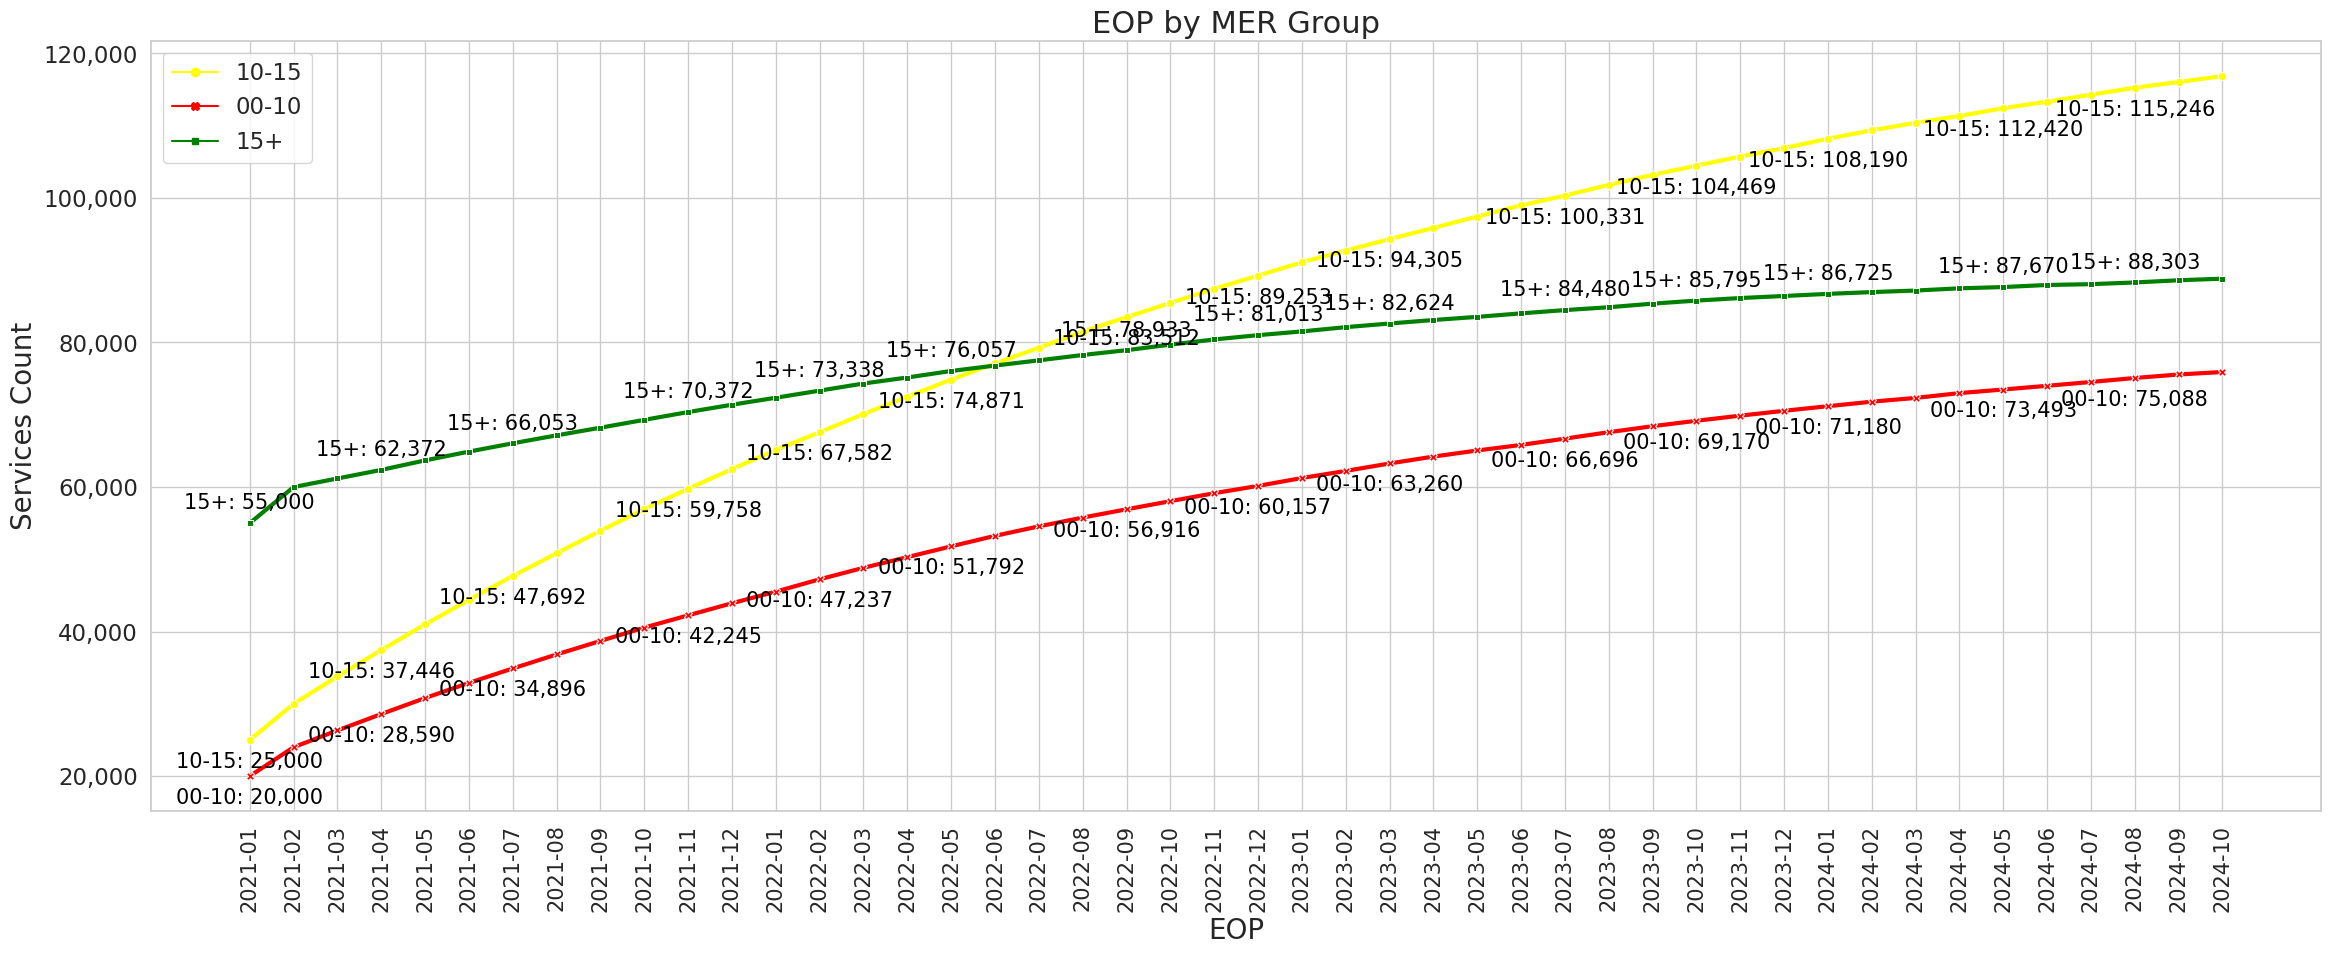

In [20]:
sns.set(style="whitegrid", font_scale=1.5)

# Create figure and axes
f, ax = plt.subplots(figsize=(28, 10))

# Plot the line chart on the primary y-axis with black color and dots
sns.lineplot(data=df, x="EOP", y="cnt", hue="MER_Group", 
             palette={'15+': 'green', '10-15': 'yellow', '00-10': 'red'}, 
             markers=True, style="MER_Group", dashes=False, linewidth=3)

# Set x-axis label and title
ax.set_xlabel('EOP', fontsize=20)
ax.set_ylabel('Services Count', fontsize=20)
ax.set_title('EOP by MER Group', fontsize=22)

ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

labels = [item.get_text()[:7] for item in ax.get_xticklabels()]  # Get the current tick labels and truncate to year and month
ax.set_xticklabels(labels, rotation=90, fontsize=15)  # Set the modified tick labels

plt.xticks(rotation=90)
plt.legend()

# Add annotations for 'Group_A' and 'Group_B' every 10 ticks
for index, value in enumerate(df['EOP']):
    if index % 10 == 0:
        for group, y_offset in zip(['15+', '10-15', '00-10'], [10, -20, -20]):
            group_values = df.loc[(df['EOP'] == value) & (df['MER_Group'] == group), 'cnt'].values
            if len(group_values) > 0:  # Check if a value exists
                group_value = group_values[0]
                ax.annotate(f'{group}: {group_value:,.0f}', (value, group_value), textcoords="offset points", 
                            xytext=(0, y_offset), ha='center', fontsize=15, color='black')

            
# Show the plot
plt.savefig("BASE_BY_MER_GROUP.png",transparent=True,bbox_inches='tight',pad_inches=0.05,dpi=400) 
plt.show()            

## DEACTIVATIONS

### Deactivations Per Month

In [21]:
%%time

df  = spark.sql("""
SELECT EOP, 
avg(Product_MER) mer,
count(*) cnt 
from Tx_Renewals AL1
LEFT JOIN Dim_Products AL2 ON AL1.Plan_ID = AL2.Plan_ID
Where Status = 'Closed'
Group by EOP
ORDER BY 1""").toPandas()
df.head(4)

CPU times: user 18.4 ms, sys: 2.66 ms, total: 21 ms
Wall time: 2.88 s


,EOP,mer,cnt
0,2021-02-28,15.344372,6702
1,2021-03-31,15.210464,6890
2,2021-04-30,14.996208,6927
3,2021-05-31,14.886448,7291


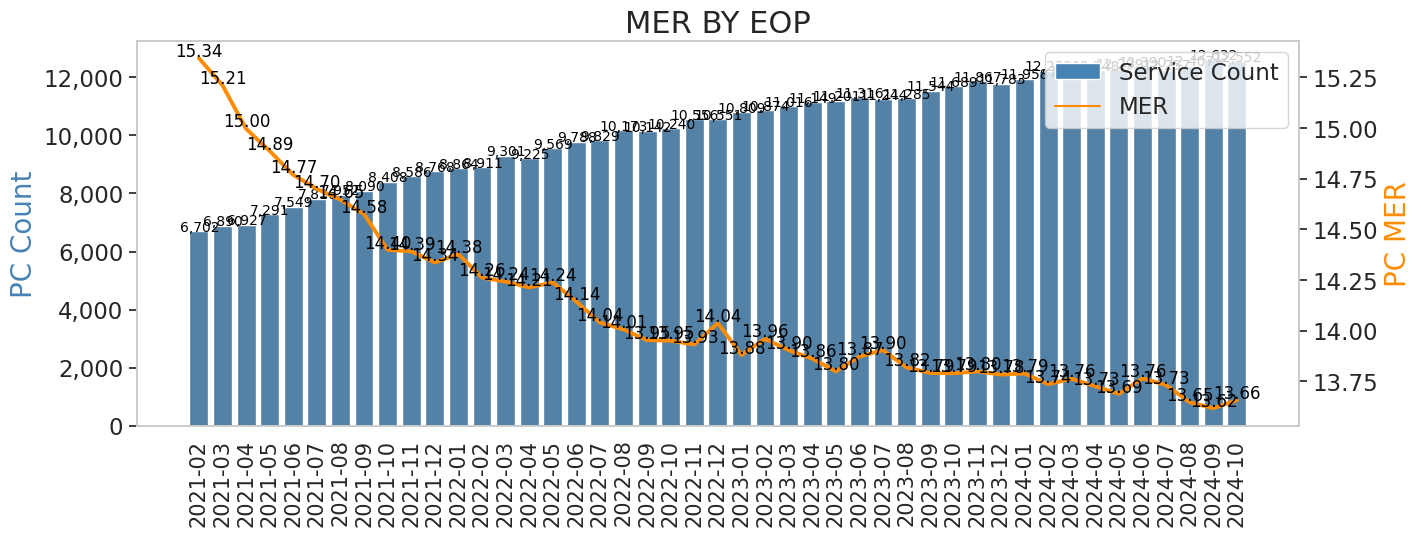

In [22]:
x = pd.Series(df['EOP'])  # Convert to pandas Series
y1 = df['cnt']
y2 = df['mer']

# Handle infinite values explicitly
df.replace([float('inf'), -float('inf')], float('nan'), inplace=True)

sns.set(style="whitegrid", font_scale=1.5)

# Create figure and axes
f, ax1 = plt.subplots(figsize=(15, 5),frameon = True)

# Plot the bar chart on the primary y-axis
bar = sns.barplot(x=x, y=y1, ax=ax1, color='steelblue')
ax1.set_ylabel('PC Count', color='steelblue', fontsize=20)
#ax1.set_ylim([2050000, 2250000])

# Add values on top of the bars
for i, v in enumerate(y1):
    ax1.text(i + 0.02, v + 2, '{:,.0f}'.format(v), color='black', ha='center',fontsize=10)

plt.xticks(rotation=90) 
ax2 = ax1.twinx()

# Plot the line chart on the secondary y-axis
line = sns.lineplot(x=x, y=y2, ax=ax2, color='darkorange',linewidth=2.8,markers=True,markersize=11)
ax2.set_ylabel('PC MER', color='darkorange', fontsize=20)
ax2.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x)))

# Add values on top of the bars
for i, v in enumerate(y2):
    ax2.text(i + 0.01, v + 0.01, '{:,.2f}'.format(v), color='black', ha='center',fontsize=12)

labels = [item.get_text()[:7] for item in ax1.get_xticklabels()]  # Get the current tick labels and truncate to year and month
ax1.set_xticklabels(labels, rotation=90, fontsize=15)  # Set the modified tick labels    
        
# Set x-axis label and title
ax1.set_xlabel('', fontsize=12)
ax1.set_title('MER BY EOP', fontsize=22)
ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

# Create legend with proxy artists
legend_labels = ['Service Count', 'MER']
legend_elements = [Patch(facecolor='steelblue', label='Bar Plot'),
                   Line2D([0], [0], color='darkorange', label='Line Plot')]
plt.legend(handles=legend_elements, labels=legend_labels)

# Disable the background grid lines
ax1.grid(False)
ax2.grid(False)

# Show the plot
plt.savefig("DEACT_AND_MER.png",transparent=True,bbox_inches='tight',pad_inches=0.05,dpi=400) 
plt.show()

## Deactivations by Rason Code

In [23]:
%%time

df  = spark.sql("""
SELECT EOP, 
Reason_Description,Reason_Category,
count(*) cnt 
from Tx_Renewals AL1
LEFT JOIN Dim_Cancellation_Reasons AL2 ON AL1.Reason_ID = AL2.Reason_ID
Where Status = 'Closed'
Group by EOP,Reason_Description,Reason_Category
ORDER BY 1""").toPandas()
df.head(4)

CPU times: user 17 ms, sys: 3.01 ms, total: 20 ms
Wall time: 2.58 s


,EOP,Reason_Description,Reason_Category,cnt
0,2021-02-28,Service terminated by company,Non-voluntary,6702
1,2021-03-31,Non-payment,Non-voluntary,6890
2,2021-04-30,Violation of terms and conditions,Non-voluntary,6927
3,2021-05-31,Dissatisfaction with service,Voluntary,7291


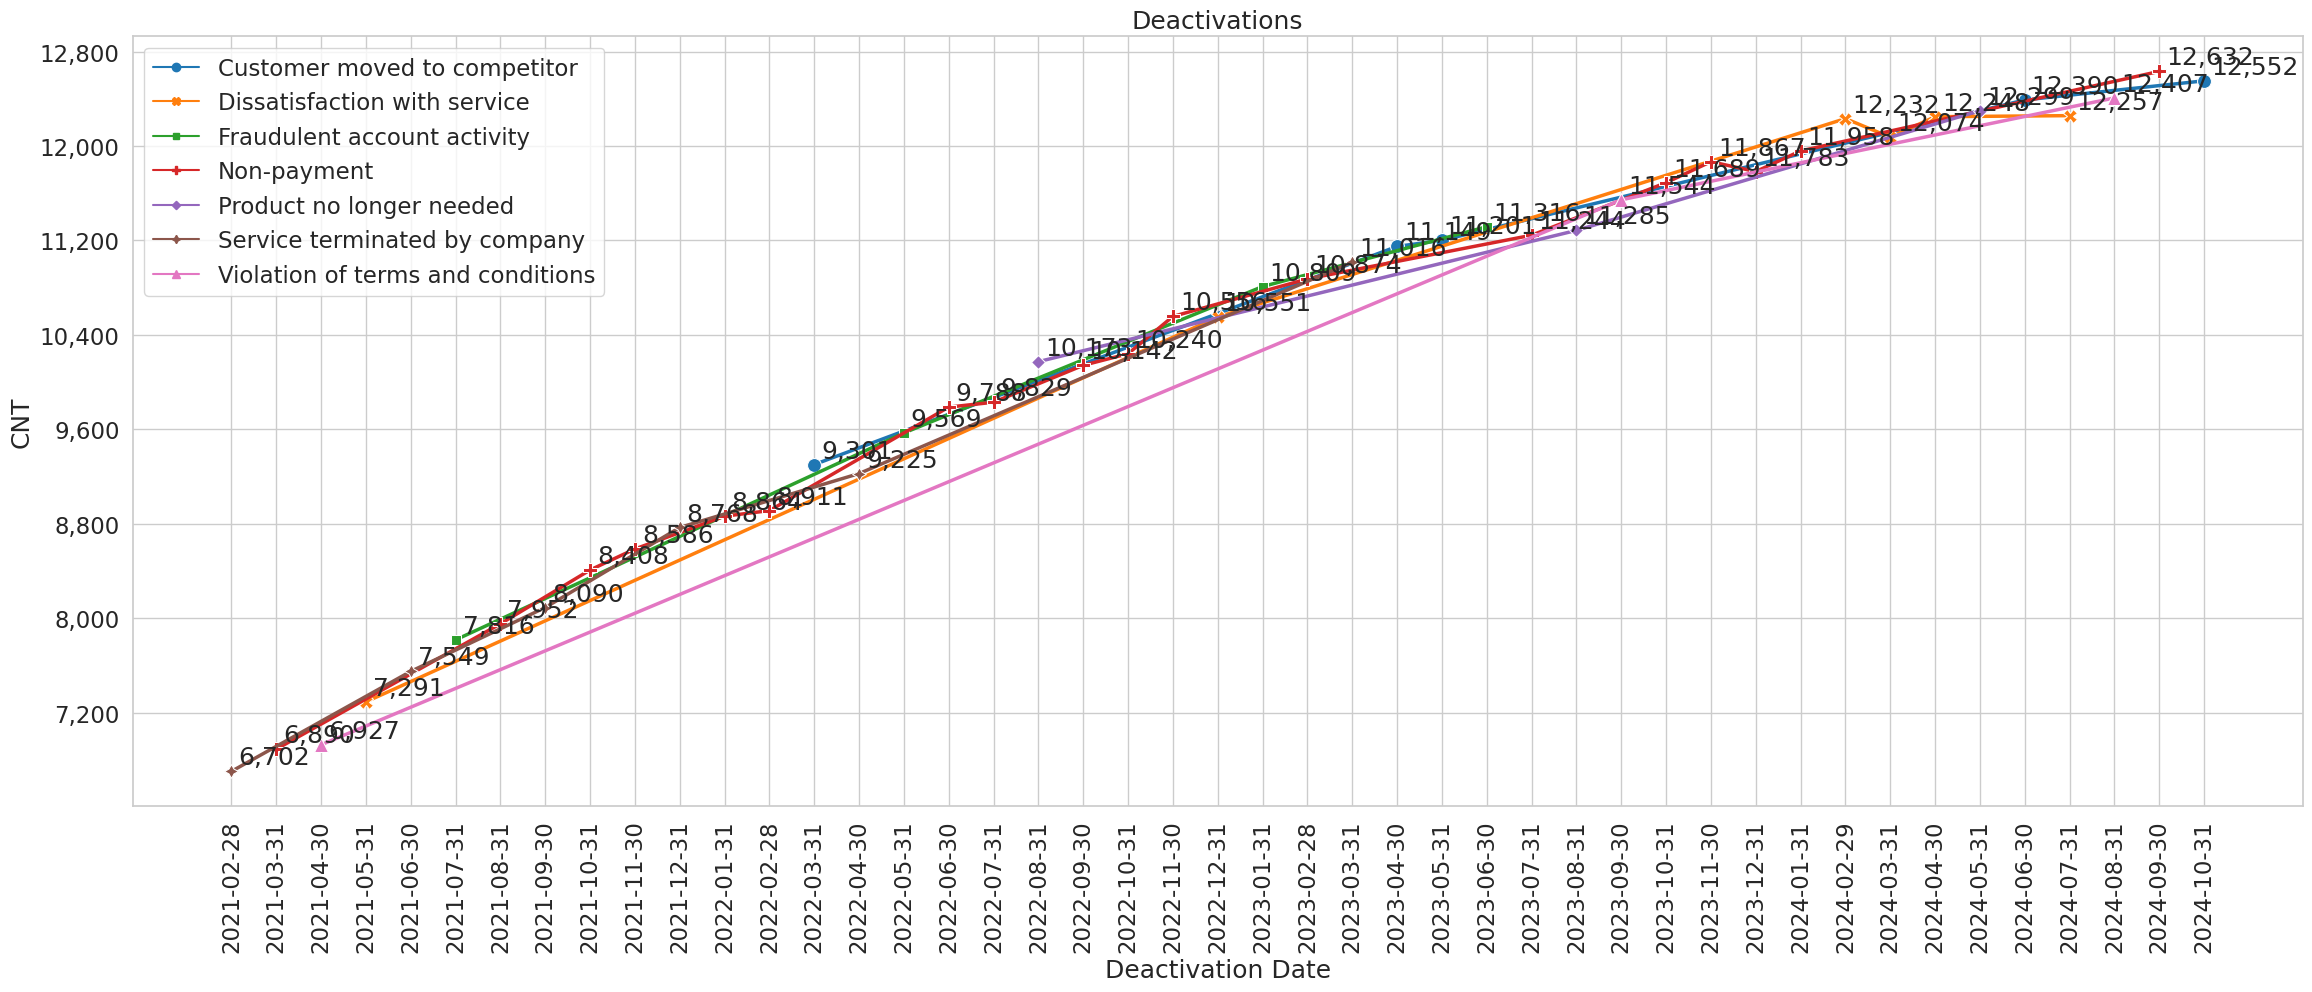

In [24]:
final_df = df
final_df = final_df[['EOP','Reason_Description','cnt']]
final_df = final_df.groupby(['EOP','Reason_Description']).sum()
final_df = final_df.reset_index()
final_df = final_df.pivot(index='EOP', columns='Reason_Description', values='cnt')

sns.set(style="whitegrid", font_scale=1.5)
fig, ax = plt.subplots(figsize=(28, 10),frameon =True)
sns.lineplot(data=final_df, palette="tab10", linewidth=2.5, markers=True, dashes=False, markersize=10, ax=ax)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

ax.set_xticks(final_df.index)
ax.set_xlabel('Deactivation Date')
ax.set_ylabel('CNT')
ax.set_title('Deactivations')
ax.legend(loc='upper left')
#plt.ylim(0, 1000)

ax.yaxis.set_major_locator(mtick.MaxNLocator(integer=True))  # Set y-axis ticks as integers
plt.xticks(rotation=90) 

for index, row in final_df.iterrows():
    y_list = []    
    for col in row:                
        if not math.isnan(col):            
            display_flag = 1
            for value in y_list:
                if abs(value - col) <= 350:
                    display_flag = 0
            
            if display_flag ==1:
                ax.annotate(f'{col:,.0f}', xy=(index, col), xytext=(5, 5), textcoords='offset points')            
            y_list.append(col)

plt.savefig("DEACT_AND_REASON.png", transparent=False, bbox_inches='tight', pad_inches=0.05, dpi=500)
plt.show()

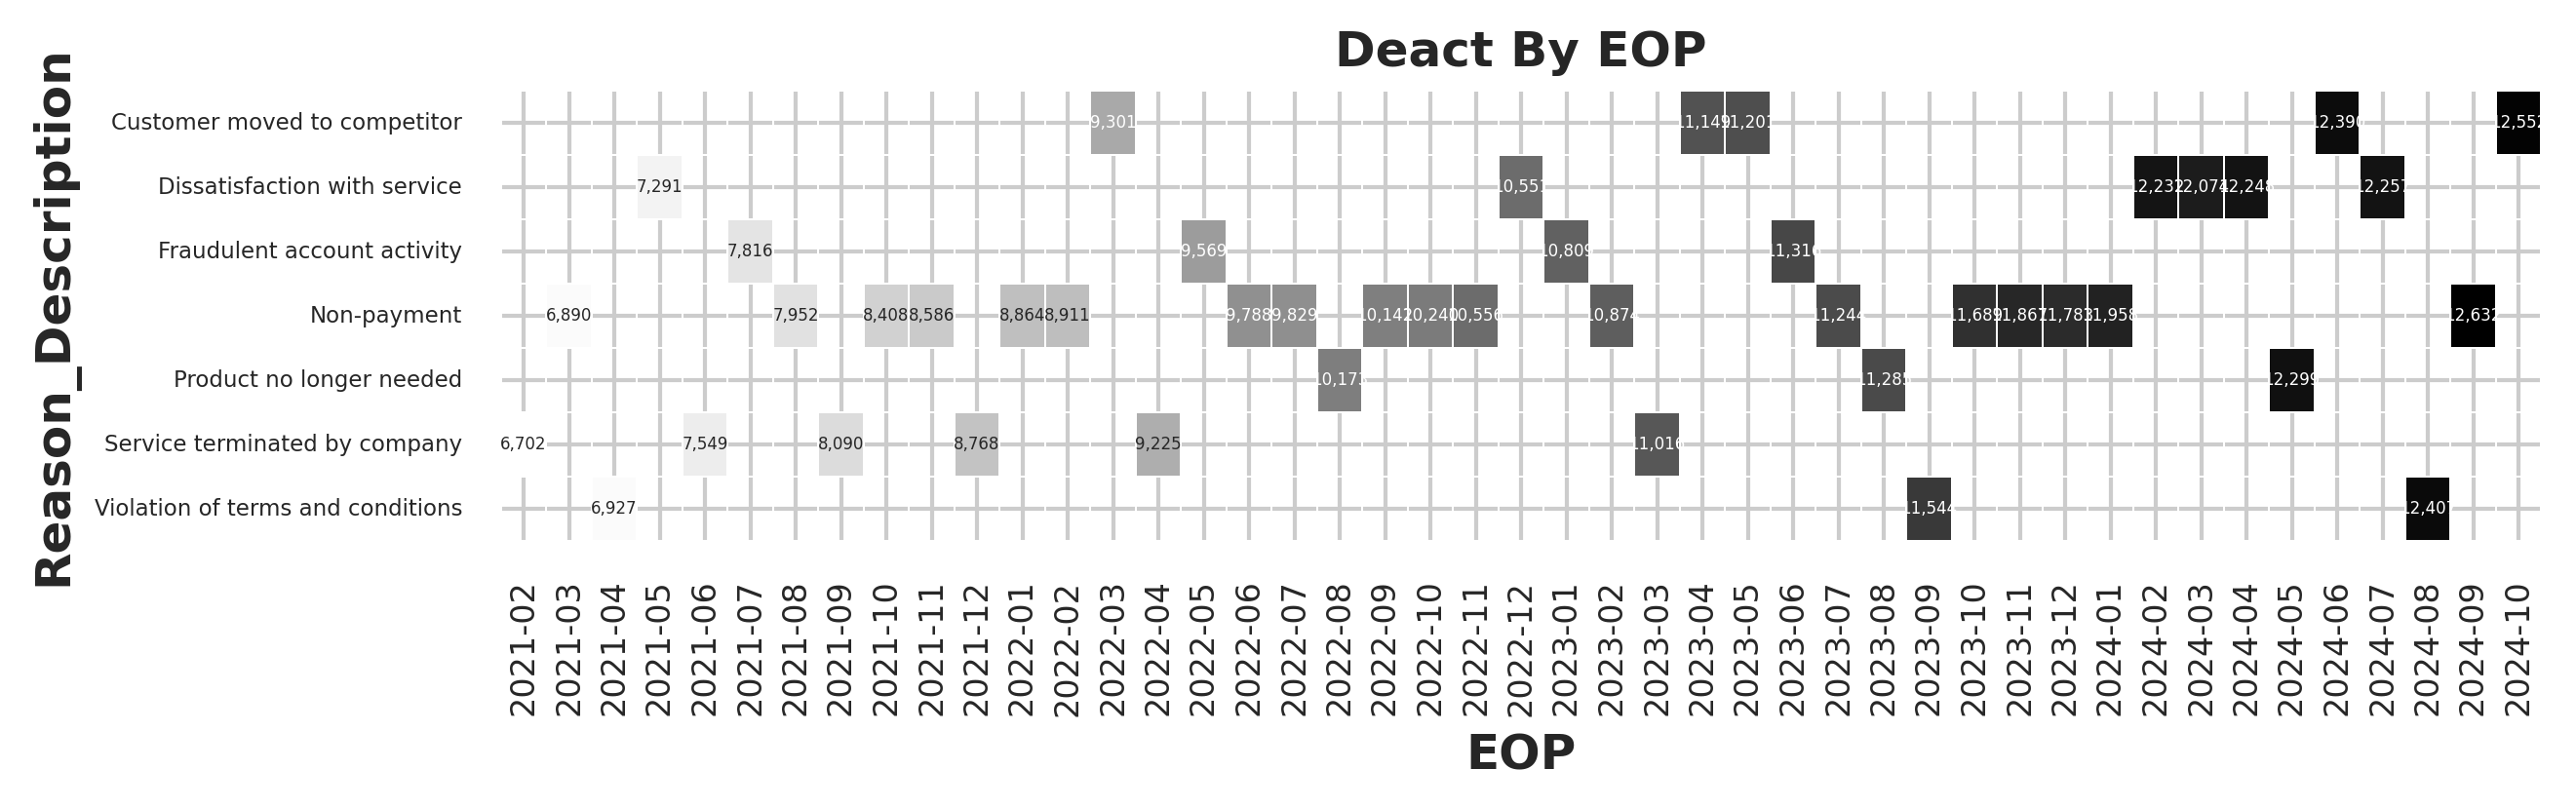

In [25]:
# Pivot the DataFrame
DATA_DF2 = df.pivot(index='Reason_Description', columns='EOP', values='cnt')

# Set Seaborn style
sns.set(style="whitegrid", font_scale=0.5)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(9, 2), dpi=300)

# Create a heatmap
sns.heatmap(DATA_DF2,
            annot=True,
            cbar=False,
            linewidths=0.1,
            annot_kws={"size": 4},
            fmt=',.0f',
            square=False,
            cmap="Greys",
            ax=ax)

# Customize tick labels
plt.yticks(rotation=0)
plt.xticks(rotation=90)

# Truncate x-axis labels to show only year and month
labels = [item.get_text()[:7] for item in ax.get_xticklabels()]
ax.set_xticklabels(labels, rotation=90, fontsize=8)

# Set axis labels and title
ax.set_xlabel('EOP', fontdict={'size': 12, 'weight': 'bold'})
ax.set_ylabel('Reason_Description', fontdict={'size': 12, 'weight': 'bold'})
ax.set_title("Deact By EOP", fontdict={'size': 12, 'weight': 'bold'})

# Drawing a red box around specific rows
rows_to_highlight = ['Silver - Individual - Annual'] 

for i, row_label in enumerate(DATA_DF2.index):
    if row_label in rows_to_highlight:
        rect = patches.Rectangle((0, i), len(DATA_DF2.columns), 1, linewidth=1, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
      
fig.savefig('BASE_BY_PLAN.png',transparent=False,  bbox_inches='tight',pad_inches=0.15,dpi=400)

## ACTIVATIONS

### Activations By Month

In [26]:
%%time

df  = spark.sql("""
SELECT AL1.EOP,
count(*) cnt 
from Tx_Renewals AL1
LEFT JOIN Tx_Renewals AL2 ON AL1.EOP = LAST_DAY(ADD_MONTHS(AL2.EOP, 1)) and AL1.Sub_ID = AL2.Sub_ID
WHERE AL2.Sub_ID is null
and AL1.Status not in ('Closed')
Group by AL1.EOP,AL2.EOP
ORDER BY 1""").toPandas()
df.head(4)

CPU times: user 51.3 ms, sys: 13.6 ms, total: 64.9 ms
Wall time: 47.7 s


,EOP,cnt
0,2021-01-31,100000
1,2021-02-28,14000
2,2021-03-31,14000
3,2021-04-30,14000


## RENEWALS

### Renewals By Plan

In [27]:
%%time

df  = spark.sql("""
SELECT 
    EOP, Product_Name,Product_MER,count(*) CNT 
from Tx_Renewals AL1
LEFT JOIN Dim_Products AL2 ON AL1.Plan_ID = AL2.Plan_ID
Where Status = 'Active'
    AND EOP = LAST_DAY(ADD_MONTHS(AL1.PlanEnd, -1))
Group By EOP, Product_Name,Product_MER
Order by EOP
""").toPandas()
df.head(4)

CPU times: user 25.4 ms, sys: 4.07 ms, total: 29.4 ms
Wall time: 4.85 s


,EOP,Product_Name,Product_MER,CNT
0,2021-01-31,Bronze - Student - Monthly,6.99,5000
1,2021-01-31,Bronze - Duo - Monthly,17.99,5000
2,2021-01-31,Bronze - Family - Monthly,20.99,30000
3,2021-01-31,Bronze - Individual - Monthly,12.99,10000


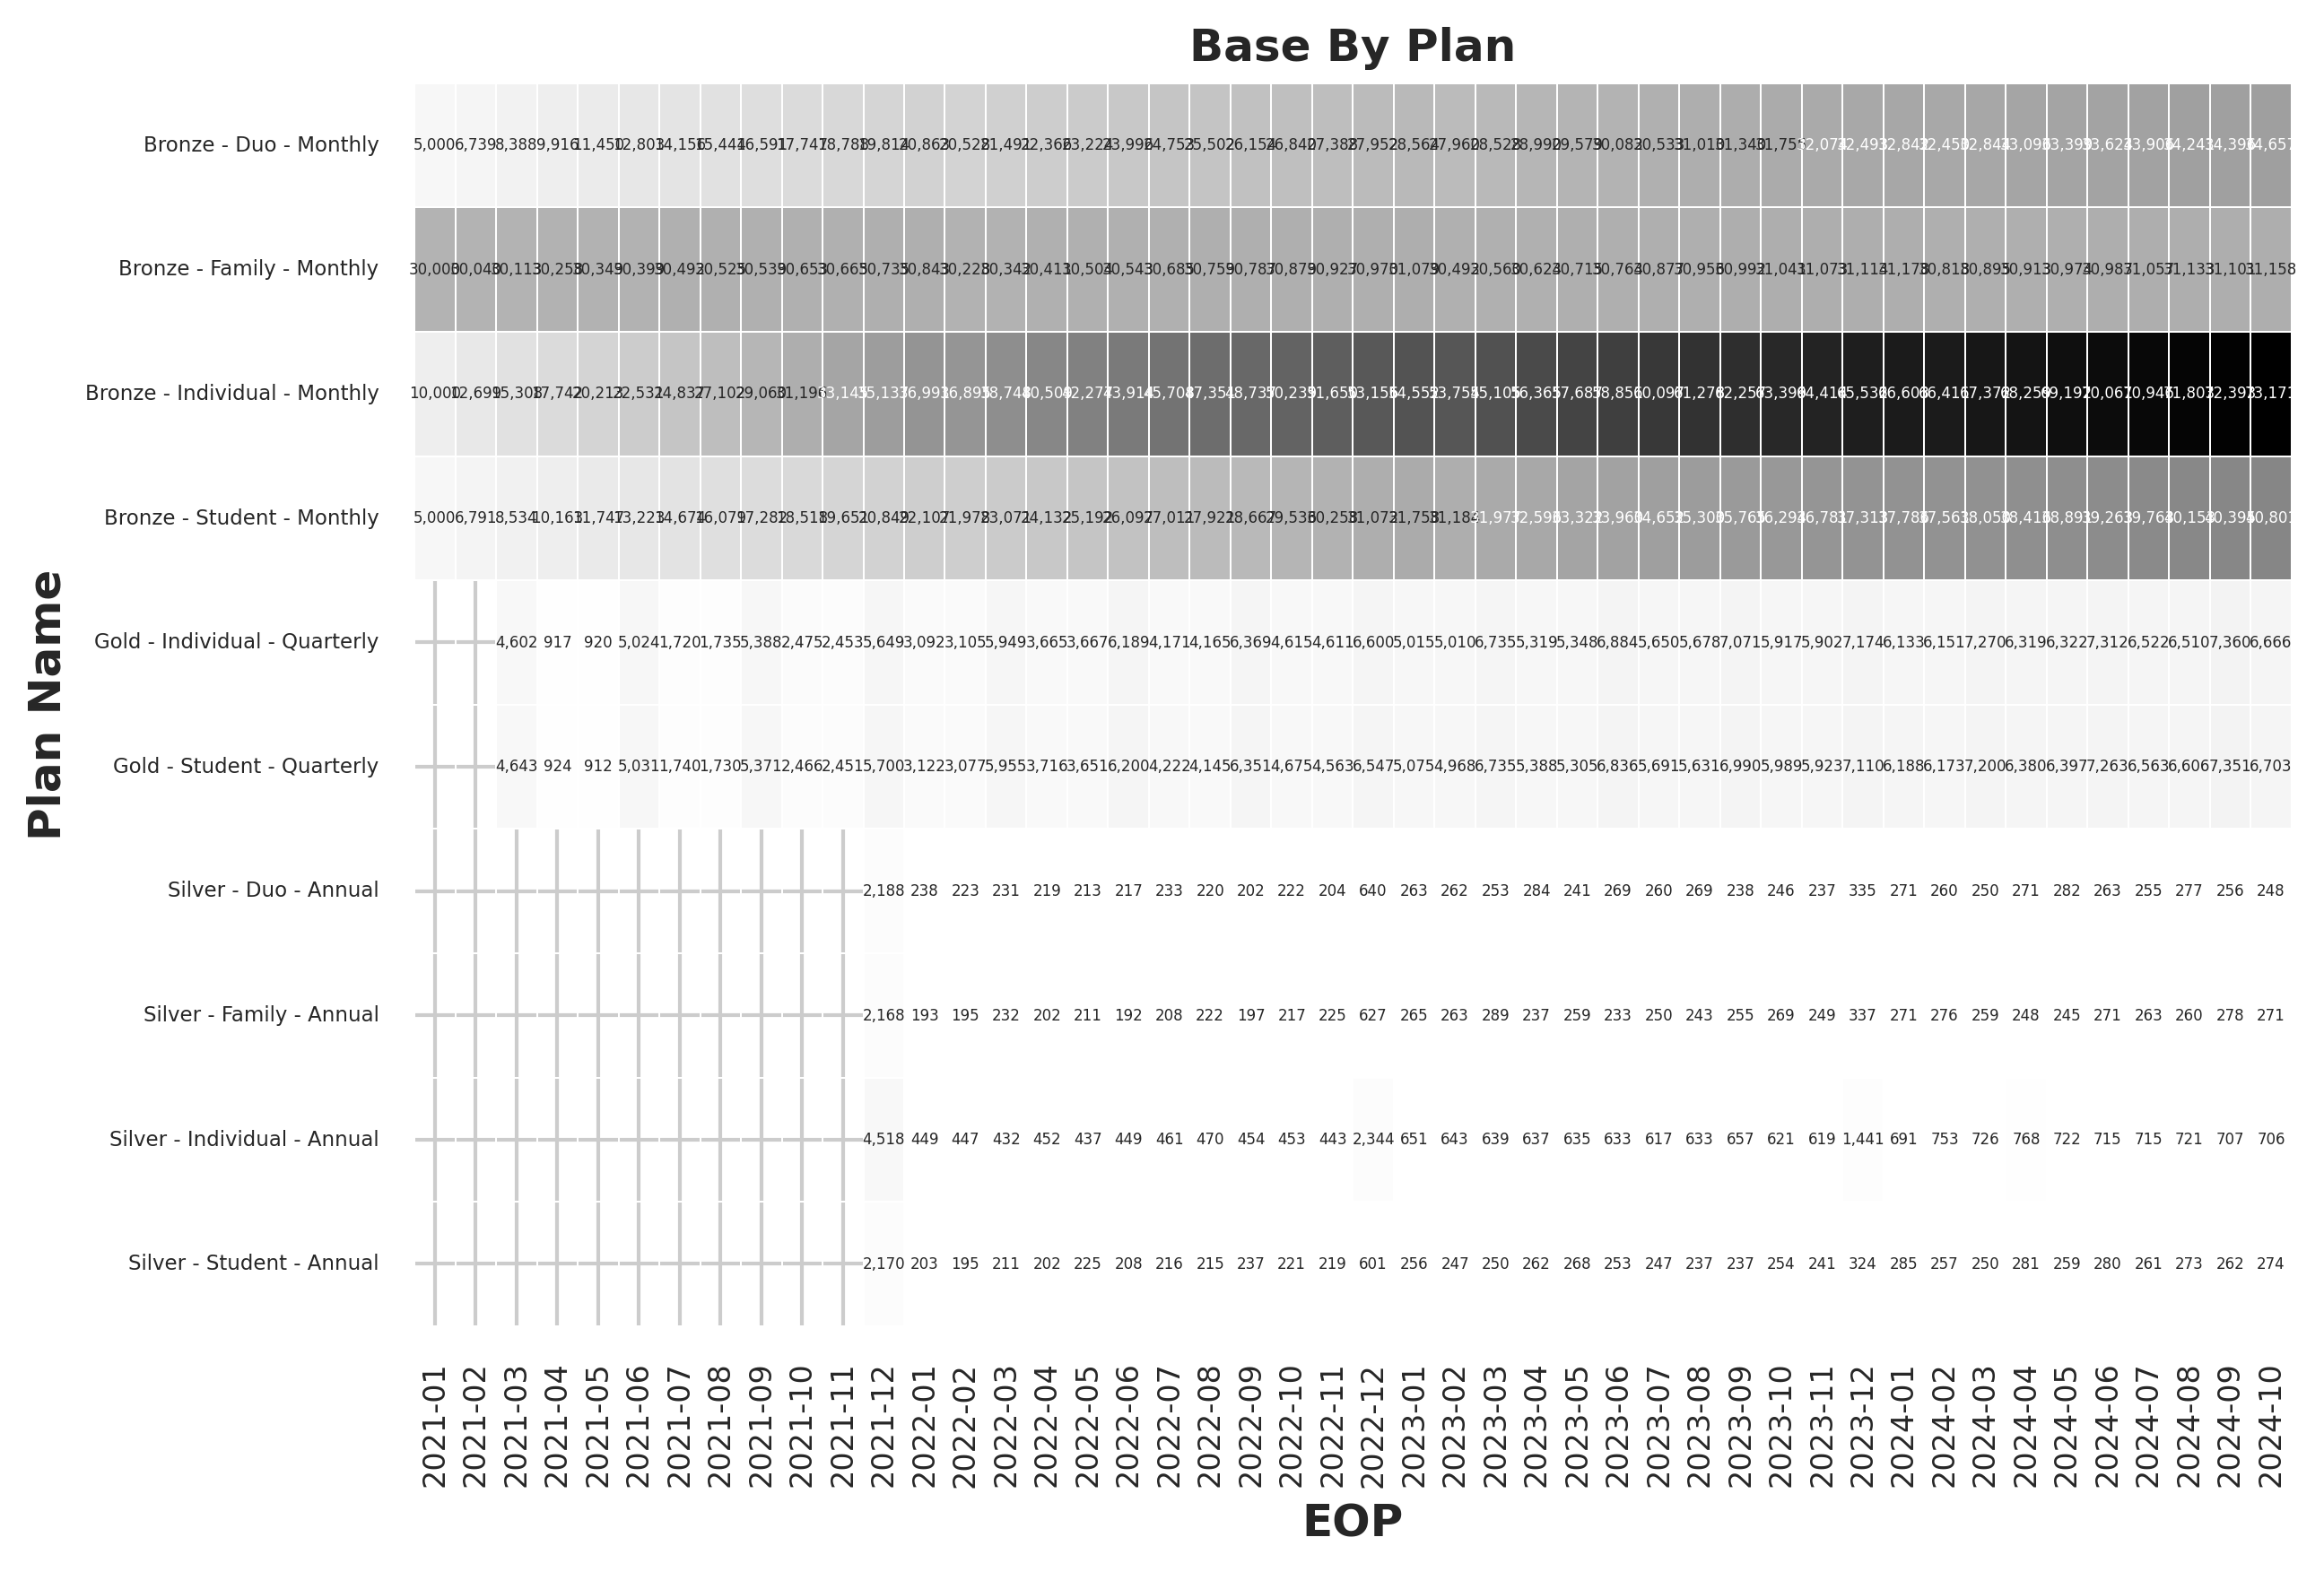

In [28]:
# Pivot the DataFrame
DATA_DF2 = df.pivot(index='Product_Name', columns='EOP', values='CNT')

# Set Seaborn style
sns.set(style="whitegrid", font_scale=0.5)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(9, 6), dpi=300)

# Create a heatmap
sns.heatmap(DATA_DF2,
            annot=True,
            cbar=False,
            linewidths=0.1,
            annot_kws={"size": 4},
            fmt=',.0f',
            square=False,
            cmap="Greys",
            ax=ax)

# Customize tick labels
plt.yticks(rotation=0)
plt.xticks(rotation=90)

# Truncate x-axis labels to show only year and month
labels = [item.get_text()[:7] for item in ax.get_xticklabels()]
ax.set_xticklabels(labels, rotation=90, fontsize=8)

# Set axis labels and title
ax.set_xlabel('EOP', fontdict={'size': 12, 'weight': 'bold'})
ax.set_ylabel('Plan Name', fontdict={'size': 12, 'weight': 'bold'})
ax.set_title("Base By Plan", fontdict={'size': 12, 'weight': 'bold'})

# Drawing a red box around specific rows
rows_to_highlight = ['Gold','Silver'] 

for i, row_label in enumerate(DATA_DF2.index):
    if row_label in rows_to_highlight:
        rect = patches.Rectangle((0, i), len(DATA_DF2.columns), 1, linewidth=1, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

fig.savefig('BASE_BY_PLAN.png',transparent=False,  bbox_inches='tight',pad_inches=0.15,dpi=400)

### Active Renewal Rate By Plan (2 Months After Renewal)

In [29]:
%%time

df  = spark.sql("""
SELECT 
    AL1.*,AL3.Status M2_Status, AL3.Reason_ID M2_Reason_ID,AL2.Product_Name
from Tx_Renewals       AL1
LEFT JOIN Dim_Products AL2 ON AL1.Plan_ID = AL2.Plan_ID
LEFT JOIN Tx_Renewals  AL3 ON AL1.EOP = LAST_DAY(ADD_MONTHS(AL3.EOP, -2)) and AL1.Sub_ID = AL3.Sub_ID
Where 
    AL1.Status = 'Active'
    AND AL1.EOP = LAST_DAY(ADD_MONTHS(AL1.PlanEnd, -1))
""")
# Save the DataFrame as a new Spark table
df.write.mode("overwrite").saveAsTable("sonify.temp_renewal_rate")


df  = spark.sql("""SELECT *,
       CASE 
           WHEN CAST(M2_Reason_ID AS FLOAT) IS NOT NULL THEN 1
           ELSE 0
       END AS M2_Status_Num
FROM temp_renewal_rate""")
# Save the DataFrame as a new Spark table
df.write.mode("overwrite").saveAsTable("sonify.temp_renewal_rate2")


# Final Select
df  = spark.sql("""SELECT EOP, AVG(M2_Status_Num)*100 Act_Rate, count(*) CNT FROM temp_renewal_rate2 Group By EOP ORDER BY EOP""").toPandas()
df.head(4)

CPU times: user 69.4 ms, sys: 24.5 ms, total: 93.9 ms
Wall time: 1min 2s


,EOP,Act_Rate,CNT
0,2021-01-31,3.226000,50000
1,2021-02-28,3.110061,56269
2,2021-03-31,3.338548,71588
3,2021-04-30,3.318078,69920


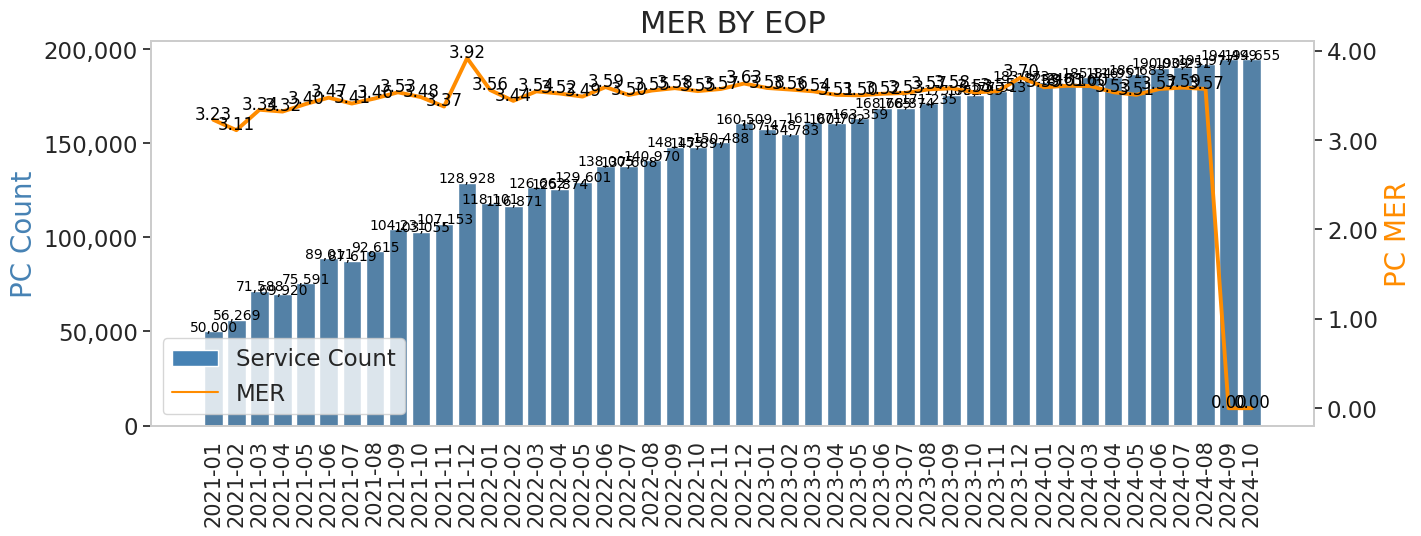

In [30]:
x = pd.Series(df['EOP'])  # Convert to pandas Series
y1 = df['CNT']
y2 = df['Act_Rate']

# Handle infinite values explicitly
df.replace([float('inf'), -float('inf')], float('nan'), inplace=True)

sns.set(style="whitegrid", font_scale=1.5)

# Create figure and axes
f, ax1 = plt.subplots(figsize=(15, 5),frameon = True)

# Plot the bar chart on the primary y-axis
bar = sns.barplot(x=x, y=y1, ax=ax1, color='steelblue')
ax1.set_ylabel('PC Count', color='steelblue', fontsize=20)
#ax1.set_ylim([2050000, 2250000])

# Add values on top of the bars
for i, v in enumerate(y1):
    ax1.text(i + 0.02, v + 0, '{:,.0f}'.format(v), color='black', ha='center',fontsize=10)

plt.xticks(rotation=90) 
ax2 = ax1.twinx()

# Plot the line chart on the secondary y-axis
line = sns.lineplot(x=x, y=y2, ax=ax2, color='darkorange',linewidth=2.8,markers=True,markersize=11)
ax2.set_ylabel('PC MER', color='darkorange', fontsize=20)
ax2.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x)))

# Add values on top of the bars
for i, v in enumerate(y2):
    ax2.text(i + 0.01, v + 0.01, '{:,.2f}'.format(v), color='black', ha='center',fontsize=12)

labels = [item.get_text()[:7] for item in ax1.get_xticklabels()]  # Get the current tick labels and truncate to year and month
ax1.set_xticklabels(labels, rotation=90, fontsize=15)  # Set the modified tick labels    
        
# Set x-axis label and title
ax1.set_xlabel('', fontsize=12)
ax1.set_title('MER BY EOP', fontsize=22)
ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

# Create legend with proxy artists
legend_labels = ['Service Count', 'MER']
legend_elements = [Patch(facecolor='steelblue', label='Bar Plot'),
                   Line2D([0], [0], color='darkorange', label='Line Plot')]
plt.legend(handles=legend_elements, labels=legend_labels)

# Disable the background grid lines
ax1.grid(False)
ax2.grid(False)

# Show the plot
plt.savefig("SP_REPORT_MER_OVERALL.png",transparent=True,bbox_inches='tight',pad_inches=0.05,dpi=400) 
plt.show()

In [31]:
# Final Select
df  = spark.sql("""SELECT EOP, Product_Name,AVG(M2_Status_Num) * 100 Act_Rate, count(*) CNT FROM temp_renewal_rate2 Group By EOP,Product_Name Order by EOP""").toPandas()
df.head(4)

,EOP,Product_Name,Act_Rate,CNT
0,2021-01-31,Bronze - Student - Monthly,3.56,5000
1,2021-01-31,Bronze - Duo - Monthly,5.02,5000
2,2021-01-31,Bronze - Individual - Monthly,2.93,10000
3,2021-01-31,Bronze - Family - Monthly,2.97,30000


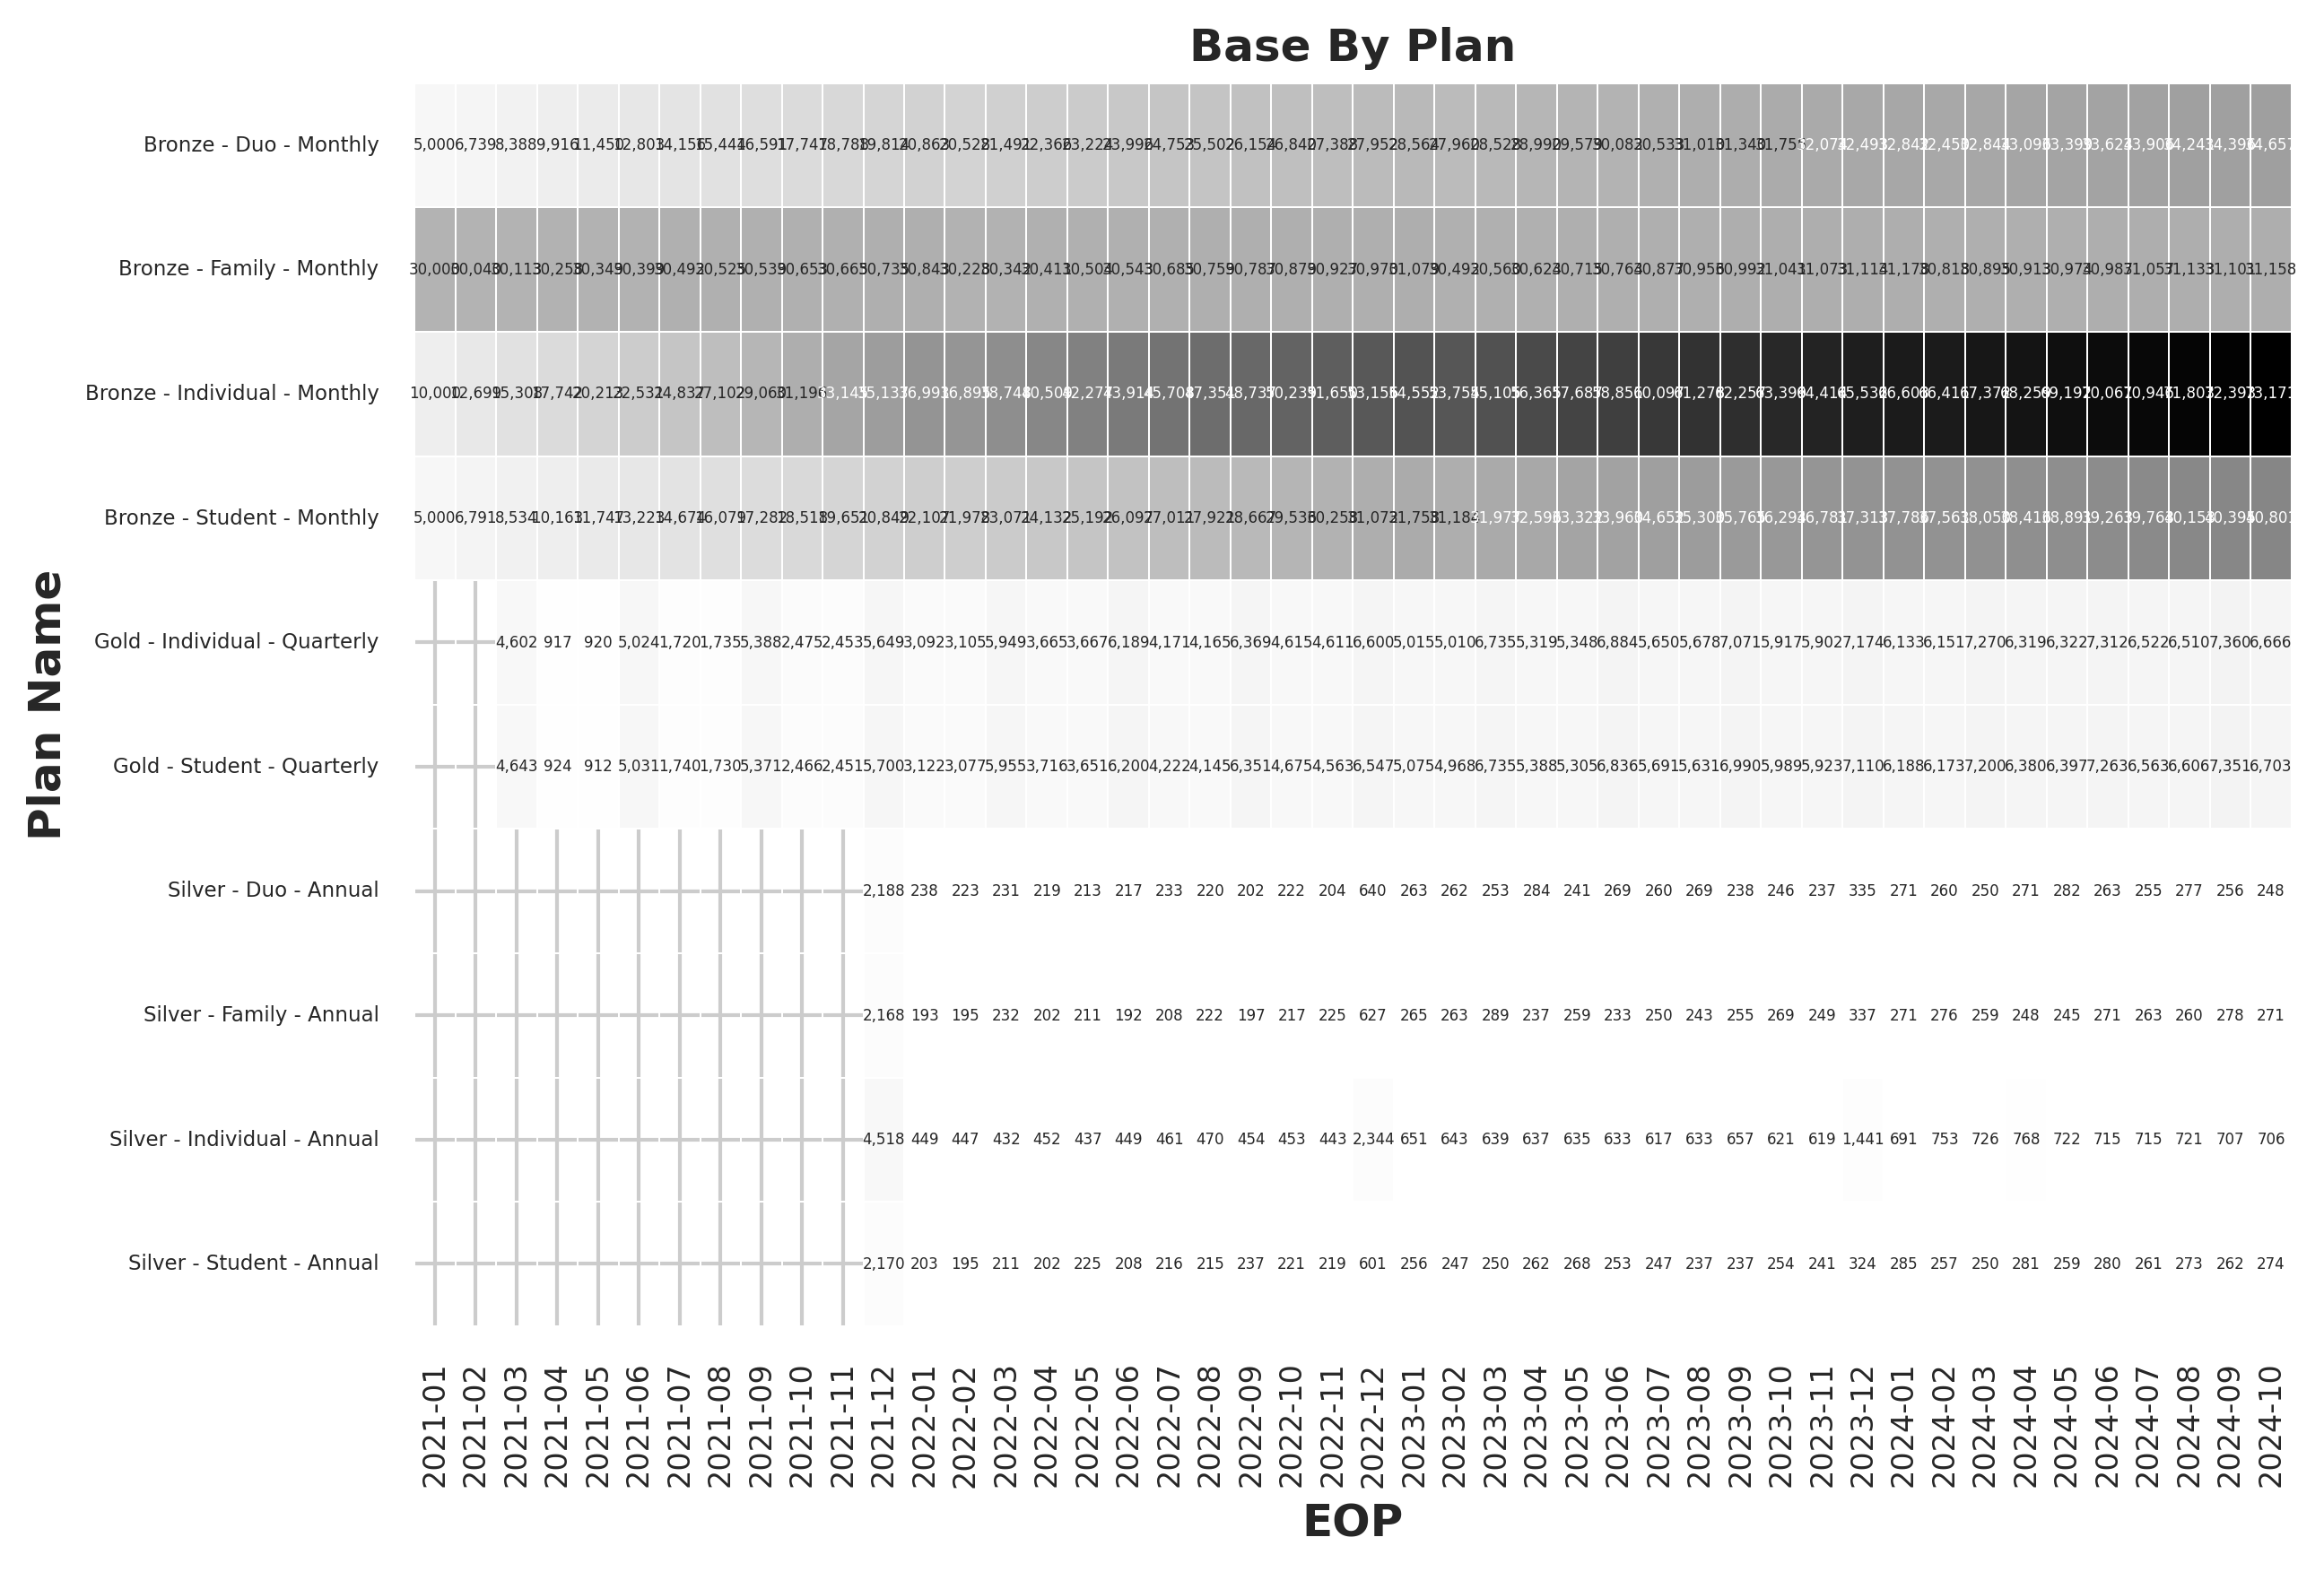

In [32]:
# Pivot the DataFrame
DATA_DF2 = df.pivot(index='Product_Name', columns='EOP', values='CNT')

# Set Seaborn style
sns.set(style="whitegrid", font_scale=0.5)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(9, 6), dpi=300)

# Create a heatmap
sns.heatmap(DATA_DF2,
            annot=True,
            cbar=False,
            linewidths=0.1,
            annot_kws={"size": 4},
            fmt=',.0f',
            square=False,
            cmap="Greys",
            ax=ax)

# Customize tick labels
plt.yticks(rotation=0)
plt.xticks(rotation=90)

# Truncate x-axis labels to show only year and month
labels = [item.get_text()[:7] for item in ax.get_xticklabels()]
ax.set_xticklabels(labels, rotation=90, fontsize=8)

# Set axis labels and title
ax.set_xlabel('EOP', fontdict={'size': 12, 'weight': 'bold'})
ax.set_ylabel('Plan Name', fontdict={'size': 12, 'weight': 'bold'})
ax.set_title("Base By Plan", fontdict={'size': 12, 'weight': 'bold'})

# Drawing a red box around specific rows
rows_to_highlight = ['Gold','Silver'] 

for i, row_label in enumerate(DATA_DF2.index):
    if row_label in rows_to_highlight:
        rect = patches.Rectangle((0, i), len(DATA_DF2.columns), 1, linewidth=1, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

fig.savefig('BASE_BY_PLAN.png',transparent=False,  bbox_inches='tight',pad_inches=0.15,dpi=400)

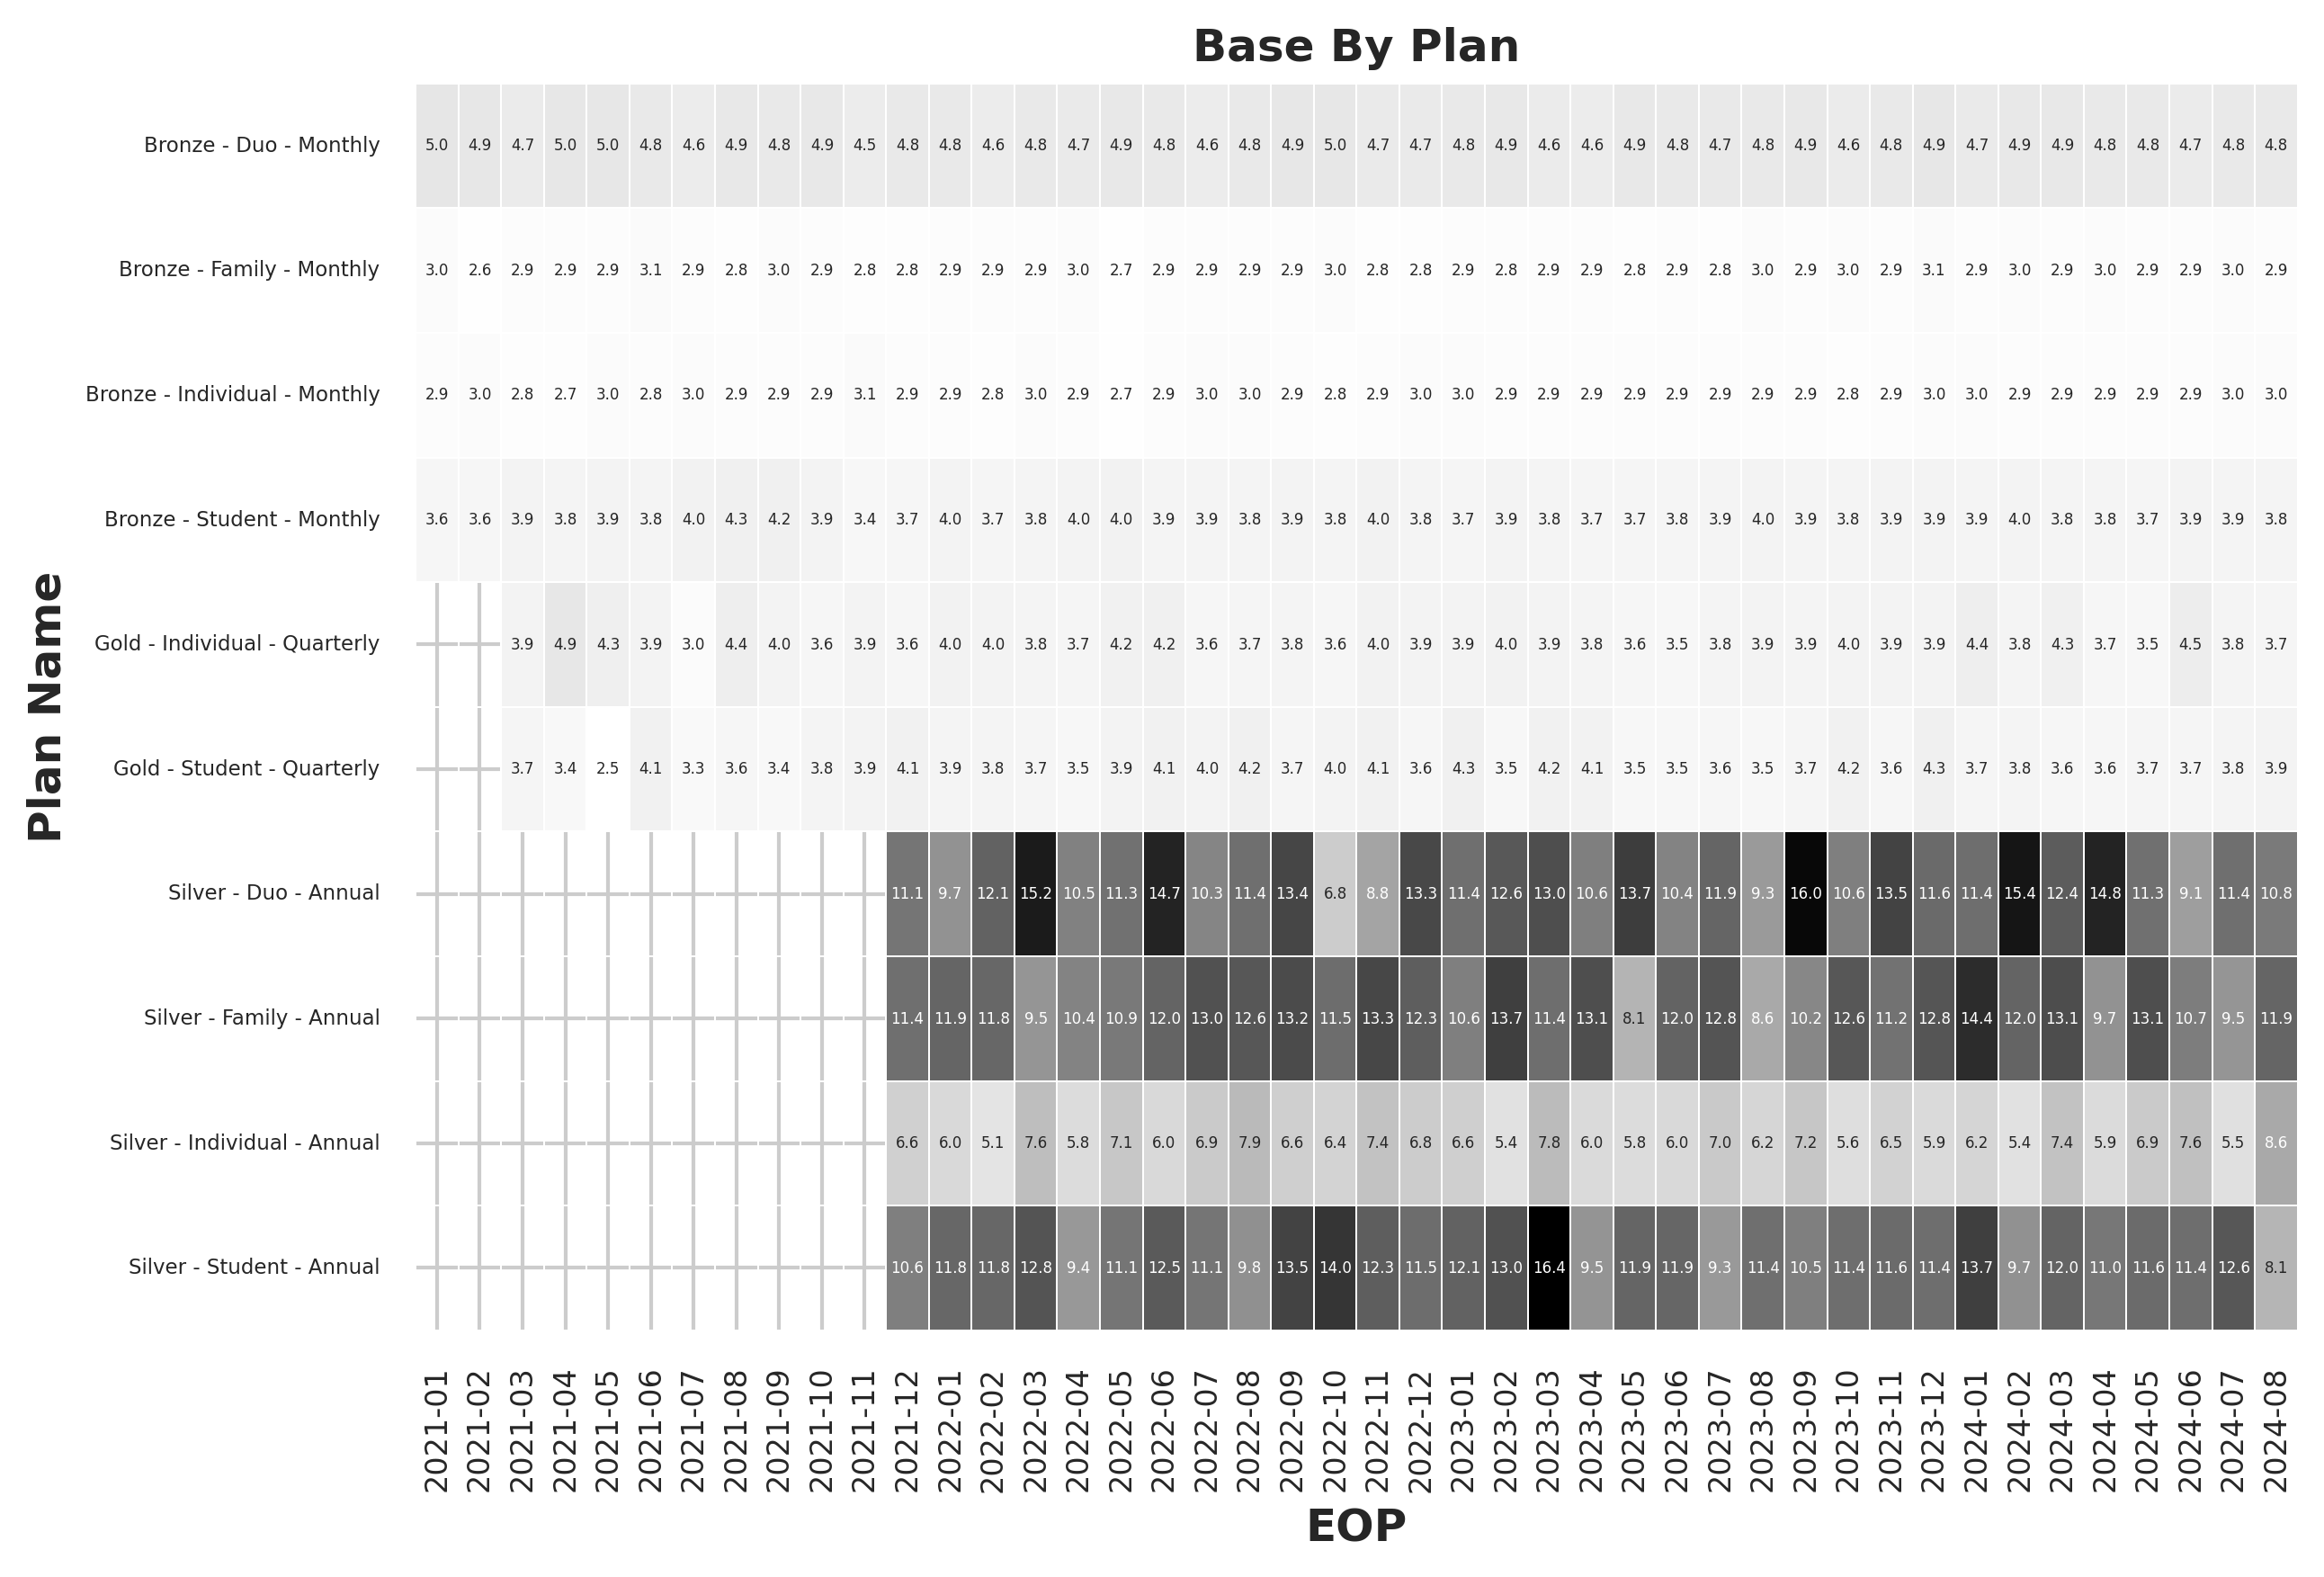

In [33]:
df1 = df.loc[df['EOP'] < '2024-09-30']

# Pivot the DataFrame
DATA_DF2 = df1.pivot(index='Product_Name', columns='EOP', values='Act_Rate')

# Set Seaborn style
sns.set(style="whitegrid", font_scale=0.5)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(9, 6), dpi=300)

# Create a heatmap
sns.heatmap(DATA_DF2,
            annot=True,
            cbar=False,
            linewidths=0.1,
            annot_kws={"size": 4},
            fmt=',.1f',
            square=False,
            cmap="Greys",
            ax=ax)

# Customize tick labels
plt.yticks(rotation=0)
plt.xticks(rotation=90)

# Truncate x-axis labels to show only year and month
labels = [item.get_text()[:7] for item in ax.get_xticklabels()]
ax.set_xticklabels(labels, rotation=90, fontsize=8)

# Set axis labels and title
ax.set_xlabel('EOP', fontdict={'size': 12, 'weight': 'bold'})
ax.set_ylabel('Plan Name', fontdict={'size': 12, 'weight': 'bold'})
ax.set_title("Base By Plan", fontdict={'size': 12, 'weight': 'bold'})

# Drawing a red box around specific rows
rows_to_highlight = ['Gold','Silver'] 

for i, row_label in enumerate(DATA_DF2.index):
    if row_label in rows_to_highlight:
        rect = patches.Rectangle((0, i), len(DATA_DF2.columns), 1, linewidth=1, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

fig.savefig('BASE_BY_PLAN.png',transparent=False,  bbox_inches='tight',pad_inches=0.15,dpi=400)

### First Renewal

## FUTURE RENEWALS

### Renewal Volume

### Renewal MER

### Renewal Rate

## TRIALS

In [34]:
# Final Select
df  = spark.sql("""SELECT * FROM TX_Trials """).toPandas()
df.head(4)

,Trial_ID,Trial_Plan_ID,PlanStart,PlanEnd,Status,Conversion_Date,Activation_Channel_ID,Bucket_ID,OEM_Name_ID,OEM_Type_ID,PRF_L1_ID,PRF_L2_ID,PRF_L3_ID,APP_Version_ID,Conversion_Plan_ID
0,100430000,5,2022-02-10 00:00:00,2023-02-10 00:00:00,Active,5,None,5,5,5,5,5,5,5,5
1,100430001,5,2022-09-15 00:00:00,2023-09-15 00:00:00,Active,5,None,5,5,5,5,5,5,5,5
2,100430002,5,2022-06-20 00:00:00,2023-06-20 00:00:00,Active,5,2023-01-12 00:00:00,5,5,5,5,5,5,5,5
3,100430003,5,2021-10-26 00:00:00,2022-10-26 00:00:00,Active,5,2021-12-15 00:00:00,5,5,5,5,5,5,5,5


## FREE MEMORY

In [35]:
def sizeof_fmt(num, suffix='B'):    
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                            df: 374.5 MiB
                           df1: 66.5 KiB
                      final_df:  6.5 KiB
                      DATA_DF2:  4.3 KiB
                             x:  3.2 KiB
                          _i14:  2.2 KiB
                          _i30:  2.0 KiB
                          _i22:  2.0 KiB
                          _i12:  2.0 KiB
                           _17:  2.0 KiB


In [36]:
for name, value in list(locals().items()):
    if isinstance(value, pd.DataFrame):
        del locals()[name]
gc.collect()        

0